## Data201 merged notebook

### Group Project
### Group member: PEI(Perry) LI, ZAHID KHAN, Kaishun(Ted) Yang Jiani Wu

In [106]:
#Import libraries
library(tidyverse)
library(readxl)
library(dplyr)
library(tidytext)
library(textdata)
library(rvest) # to scrape data from websites
library(xml2) # to effctively work with HTML or XML in R
library(magrittr) 
library(purrr)
library(glue) 
library(stringr) 
library(ggplot2)
library(sf)
library(patchwork)# to combine the graphs
library(readr)
library("zoo")
suppressWarnings(library(tidyverse))
suppressWarnings(library(readxl))

In [107]:
# Adding width and height of plots for better illustration 
options(repr.plot.width=15, repr.plot.height=8)

## Effects of Covid on Crime Rate in New Zealand

> We are certain about the crime rate will drop as the covid quarantine and lockdown could prevent crime. To prove that, we need to find the crime cases by district in New Zealand and make a graph showing the change of crime rate before and after covid period 

> 1. Read the crime rate data from the github of ministry of health 

In [108]:
# raw crime rate data 
covid_cases_data = read_csv("https://raw.githubusercontent.com/minhealthnz/nz-covid-data/main/cases/covid-cases.csv", col_names = TRUE)

Rows: 1831233 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): Case Status, Sex, Age group, DHB, Overseas travel
lgl  (1): Historical
date (1): Report Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [109]:
# Change Report Date to Date for convenience
covid_cases_data %<>% arrange('Report Date')
colnames(covid_cases_data)[1] <- "Date"

> 2. summarise the test cases by date

In [110]:
# Get the test cases by date 
summarise_data_by_date <- covid_cases_data %>% filter(covid_cases_data$"Case Status" == "Confirmed") %>% 
    group_by(Date) %>% summarise(total_cases = n())

> 3. show the change of covid test cases from 2020 to 2022

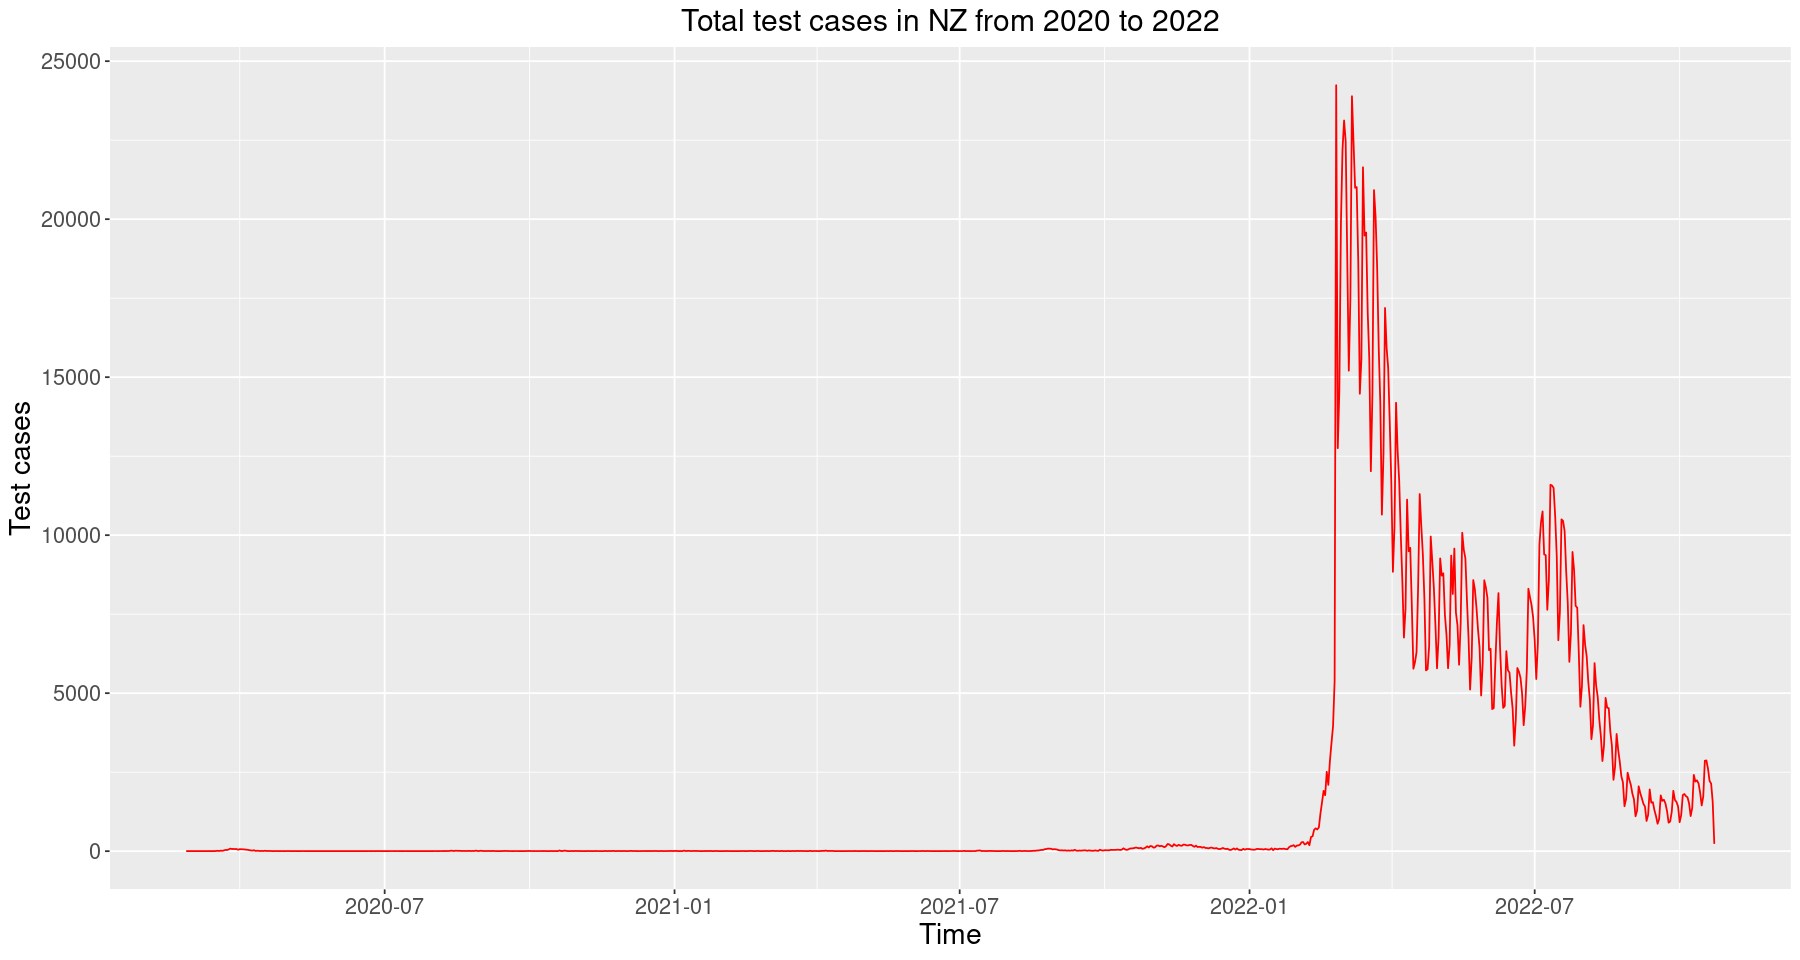

In [111]:
# Create the graph of test cases from 2020 to 2022
test_data_graph_by_date <- summarise_data_by_date %>% 
        ggplot(aes(x=Date, y=total_cases)) + 
        ggtitle('Total test cases in NZ from 2020 to 2022') + 
        geom_line(position = position_dodge(0.2), color="red") +
        # geom_point(position = position_dodge(0.2), size=2) +
        # geom_text(aes(label= total_cases), position=position_dodge(width=0.9), vjust=-0.75) +
        theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=17), 
              axis.text.x = element_text(size=13),
              axis.text.y = element_text(size=13),
              legend.title=element_blank(),
              legend.position = "right", 
              legend.text = element_text(size=14)) + 
        xlab("Time") + ylab("Test cases")
test_data_graph_by_date

> 4. then get the test cases by region and modify the name to be able to merge with crime cases table 

In [112]:
# now sorted test cases by districts
summarise_data_by_city <- covid_cases_data %>% group_by(DHB) %>% summarise(total_cases = n())

In [113]:
summarise_data_by_city[summarise_data_by_city == "Auckland"] <- "Auckland City"
summarise_data_by_city[summarise_data_by_city == "Bay of Plenty"] <- "Bay Of Plenty"
summarise_data_by_city[summarise_data_by_city == "Canterbury/West Coast"] <- "Canterbury"
summarise_data_by_city[summarise_data_by_city == "MidCentral"] <- "Central"
summarise_data_by_city[summarise_data_by_city == "Counties Manukau"] <- "Counties/Manukau"
summarise_data_by_city[summarise_data_by_city == "Hawke's Bay"] <- "Eastern"
summarise_data_by_city[summarise_data_by_city == "Nelson Marlborough"] <- "Tasman"
summarise_data_by_city[summarise_data_by_city == "Capital & Coast/Hutt"] <- "Wellington"
colnames(summarise_data_by_city)[1] <- "district"

> 5. Read the crime cases table and merge it with test cases table

In [114]:
# crime cases by region
crime_by_region <- read_csv("Data/CrimeByRegion.csv", show_col_types = FALSE)

In [115]:
# crime_by_region
colnames(crime_by_region) <- c("district", "year", "proceedings")
# Categories the year into before and after covid
crime_by_region_bf <- crime_by_region %>% 
            filter(year < "2020") %>% 
            group_by(district) %>%
            summarize(proceedings = sum(proceedings))

crime_by_region_af <- crime_by_region %>% 
            filter(year >= "2020") %>% 
            group_by(district) %>%
            summarize(proceedings = sum(proceedings))

In [116]:
# Add test cases
test_crime_bf_table <- merge(crime_by_region_bf, summarise_data_by_city, by="district")
test_crime_bf_table %<>% mutate(period = "Before")
test_crime_bf_table %<>% mutate(crime_rate = round(proceedings/sum(proceedings), 4))
# test_crime_bf_table
test_crime_af_table <- merge(crime_by_region_af, summarise_data_by_city, by="district")
test_crime_af_table %<>% mutate(period = "After")
test_crime_af_table %<>% mutate(crime_rate = round(proceedings/sum(proceedings), 4))
# test_crime_af_table
total_crime_data_table <- test_crime_bf_table %>% rbind(test_crime_af_table)

> 6. create the plot of crime cases by NZ districts

Warning message:
“position_dodge requires non-overlapping x intervals”


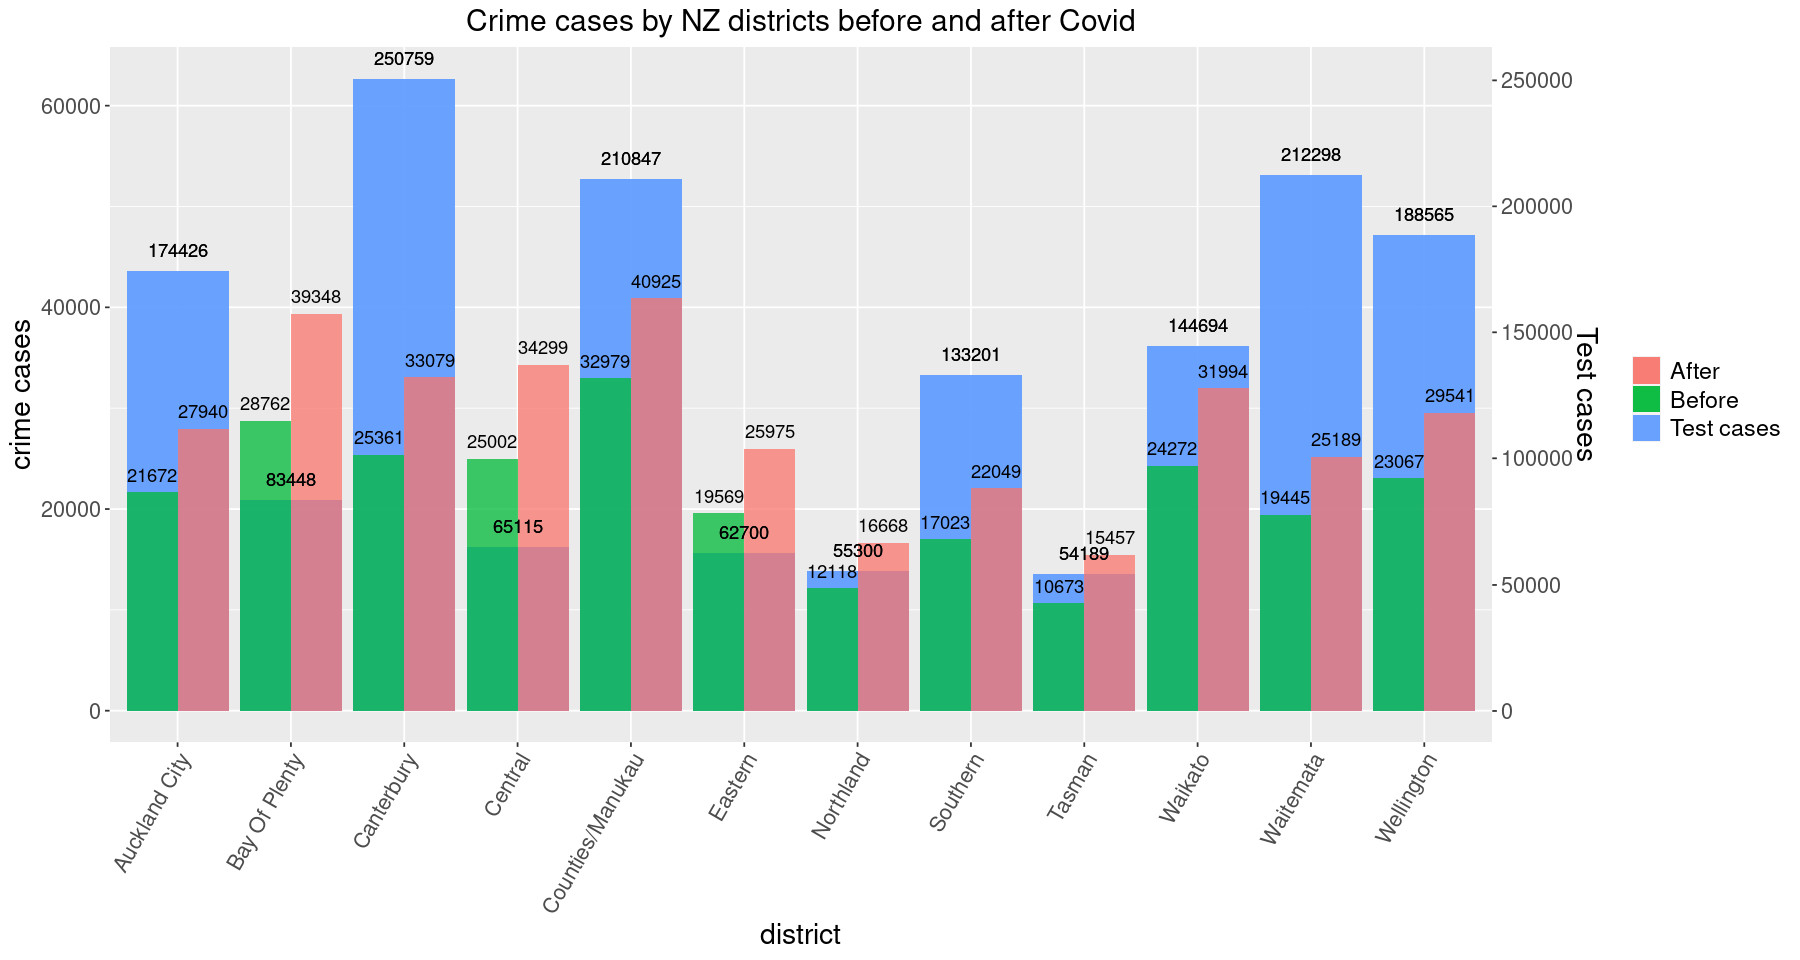

In [117]:
# build a multi bar chart to show the crime rate and test cases by different districts. 
# The left y axis is crime cases and right one is the test cases
total_crime_data_graph <- total_crime_data_table %>%
        ggplot(aes(x=district)) + 
        ggtitle('Crime cases by NZ districts before and after Covid') + 
        geom_bar(aes(y=total_cases/4, fill="Test cases"), stat = "identity", position = position_dodge(), alpha = 0.75, size = 0.5) +
        geom_bar(aes(y=proceedings, fill=period), stat = "identity", position = position_dodge(-0.9), alpha = 0.75, size = 0.5) +
        geom_text(aes(y=proceedings, label=proceedings, group=period), position=position_dodge(-0.9), vjust=-0.75) +
        geom_text(aes(y=total_cases/4, label=total_cases), position=position_dodge(width=0.2), vjust=-1) +
        theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=17), 
              axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1, size=13),
              axis.text.y = element_text(size=13),
              legend.title=element_blank(),
              legend.position = "right", 
              legend.text = element_text(size=14)) + 
        scale_y_continuous(
                name = "crime cases",
                sec.axis = sec_axis(~.*4, name="Test cases")) +
        xlab("district")
total_crime_data_graph

> 7. Read the crime cases by crime type and filter out the data we need 

In [118]:
# crime type 
crime_types <- read_csv("Data/CrimeType.csv", show_col_types = FALSE)

In [119]:
colnames(crime_types) <- c("type", "year", "method", "person", "area", "district", "month", "ethnicity", "subdivision", "proceedings")
crime_types$proceedings <- as.numeric(crime_types$proceedings)
crime_type_data <- crime_types %>% group_by(type, year) %>% summarise(cases=sum(proceedings))
crime_type_data %<>% 
        mutate(period = if_else(year < 2020, "Before", "After")) %>% 
        group_by(type, period) %>% 
        summarise(cases = sum(cases))

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.


> 8. Create the bar plot to show the crime cases by crime type

Warning message:
“position_dodge requires non-overlapping x intervals”


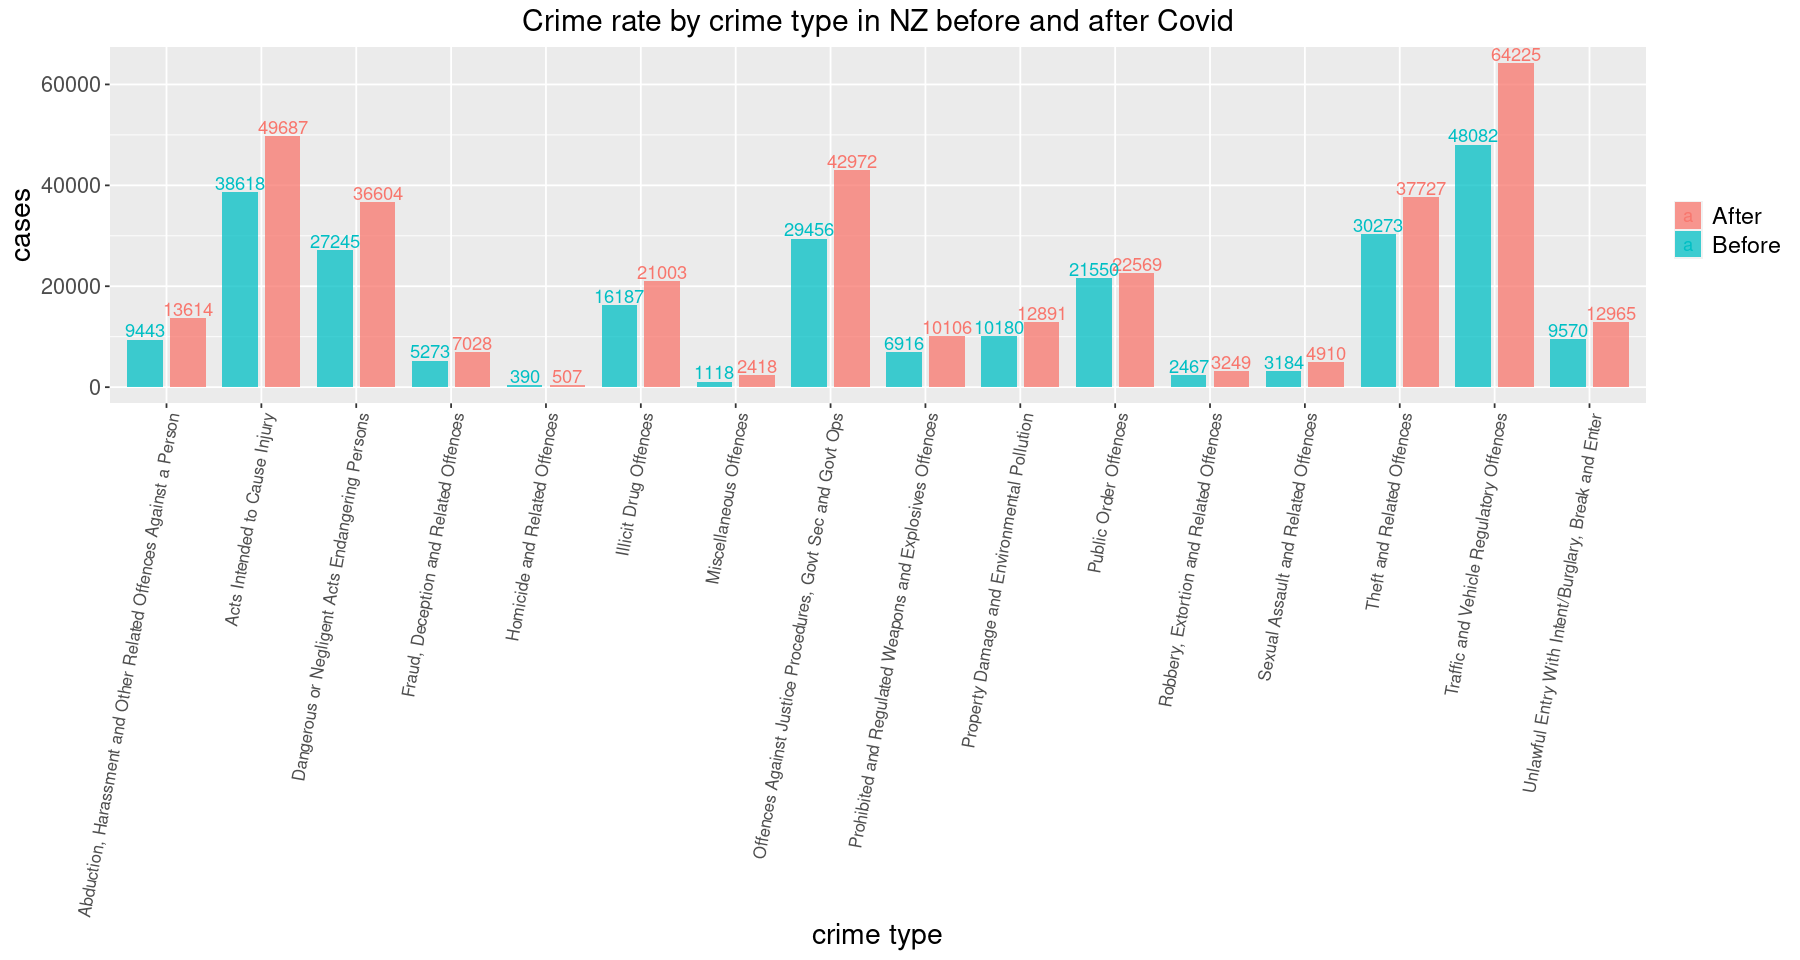

In [120]:
crime_type_data_graph <- crime_type_data %>%
        ggplot(aes(x=type, y=cases, fill=period)) + 
        ggtitle('Crime rate by crime type in NZ before and after Covid') + 
        geom_bar(stat = "identity", position = position_dodge(width = -0.9), alpha = 0.75, size = 0.5, width = 0.75) +
        geom_text(aes(label=cases, color = period), position=position_dodge(width = -0.9), vjust=-0.15) +
        theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=17), 
              axis.text.x = element_text(angle = 80, vjust = 1, hjust = 1, size=10),
              axis.text.y = element_text(size=13),
              legend.title=element_blank(),
              legend.position = "right", 
              legend.text = element_text(size=14)) +  
        xlab("crime type") + ylab("cases")
crime_type_data_graph

> 9. Read the New Zealand shapefile and merge it with crime cases by district in New Zealand

In [121]:
# nz map by region
nz_map = read_sf("Data/gadm41_NZL_1.shp")

In [122]:
# modify the crime rate data table to match the districts name
total_crime_data_table %<>% filter(period == "After") %>% 
        select(c(district, proceedings)) %>% 
        filter(!row_number() %in% c(1, 2, 4, 5, 6, 8))
sep <- data.frame(district=c("Auckland", "Counties Manukau", "Hawke\'s Bay", "Southern Islands", "Manawatu-Wanganui", "Bay of Plenty"),
        proceedings=c(16440, 22945, 14909, 12653, 19150, 22945))
total_crime_data_table %<>% rbind(sep)

In [123]:
# Get the crime rate data that two table can match district
crime_rate_table <- total_crime_data_table %>% 
  filter(district %in% nz_map$NAME_1) %>%
  group_by(district) %>%
  summarise(crime_rate = proceedings/sum(total_crime_data_table$proceedings))

nz_map$crime_rate <- crime_rate_table$crime_rate[match(nz_map$NAME_1, crime_rate_table$district)]

> 10. build the map plot to show crime rate by district in New Zealand before and after Covid

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message:
“position_dodge requires non-overlapping x intervals”


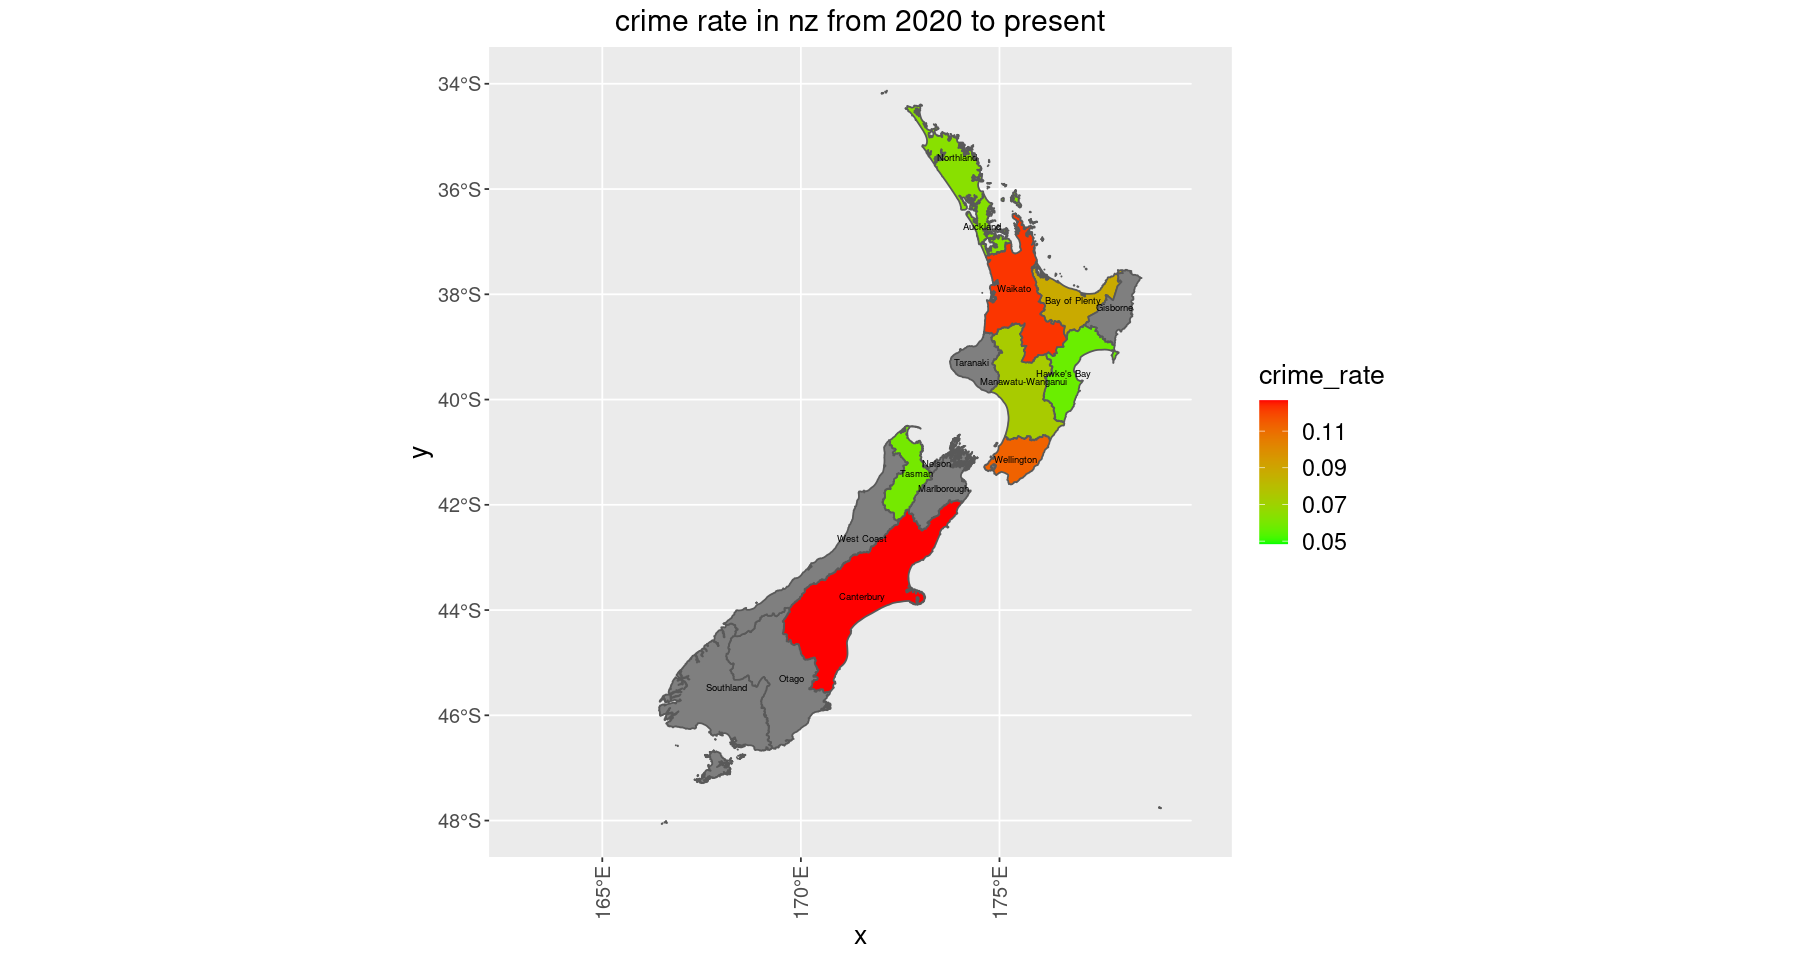

In [124]:
# display the crime rate by region on map, green means low crime rate and so is opposite to red 
crime_rate_map <- ggplot(nz_map) + 
    geom_sf(aes(fill = crime_rate)) +
    ggtitle("crime rate in nz from 2020 to present") +
    coord_sf(xlim = c(163,180),
            ylim = c(-48,-34)) +
    geom_sf_text(aes(label = NAME_1), position=position_dodge(1.7), size=2) +
    theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=16), 
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size=12),
              axis.text.y = element_text(size=12),
              legend.title = element_text(size=16),
              legend.position = "right", 
              legend.text = element_text(size=14)) +
    scale_fill_gradient(low = "green", high = "red")
crime_rate_map

## Effects of Covid on Agricultural sector

 ### Read the number of excel files of livestock before and after the covid-19 outbreak respectively

In [125]:
# agriculture
suppressMessages(livestock_2020 <- read_excel('Data/agricultural-production-statistics-june-2021-final.xlsx',sheet=2)) #Read the data about livestock after there is a outbreak
suppressMessages(livestock_2018 <- read_excel('Data/2019.xlsx',sheet=2)) #Read the data about livestock before is a outbreak

### As the imported data tables are a lot of garbage and NA, so the next step is data wrangling

> Rename the columns,remove redundant rows and columns of data and change 's' and '-' to '0' because after reviewing the data,data in the table with 's' and '-' were not counted to the final total number, also change the numbers as chr types to numeric type


In [126]:
colnames(livestock_2020) <- (c("district", "f1", "2020sheep", "2021sheep", "f2", "2020cow_cattles", "2021cow_cattles", "f3","2020beef","2021beef","f4","2020deer","2021deer","f5"))#Give the columns new names for data table which records livestocks numbers after covid and the column name starting with 'f' will be deleted later
colnames(livestock_2018) <- (c("district", "f1", "2018sheep", "2019sheep", "f2", "2018cow_cattles", "2019cow_cattles", "f3","2018beef","2019beef","f4","2018deer","2019deer","f5"))#Give the columns new names for data table which records livestocks numbers before covid and the column name starting with 'f' will be deleted later

In [127]:
livestock_2020_1<- livestock_2020[-c(1:8),] #Remove the first to eighth rows about 2020-2021 data table
livestock_2018_1<- livestock_2018[-c(1:8),] #Remove the first to eighth rows about 2018-2019 data table

In [128]:
livestock_2020_1 %<>% select(-f1,-f2,-f3,-f4,-f5)  #Use select -xxx to remove columns with column names starting with 'f'
livestock_2018_1 %<>% select(-f1,-f2,-f3,-f4,-f5)  #Use select -xxx to remove columns with column names starting with 'f'

In [129]:
livestock_2020_1 <- livestock_2020_1 %>% slice(1:20) #Use select xx to leave the data column I need
livestock_2018_1 <- livestock_2018_1 %>% slice(1:20) #Use select xx to leave the data column I need

In [130]:
#Check each columns , if there are 's' or '-' in, then change it into '0' in data from 2020-2021
livestock_2020_1$'2020sheep'[which(livestock_2020_1$'2020sheep' =='S' |livestock_2020_1$'2020cow' =='-')] <-'0'
livestock_2020_1$'2021sheep'[which(livestock_2020_1$'2021sheep' =='S' |livestock_2020_1$'2020cow' =='-')] <-'0'

livestock_2020_1$'2020cow_cattles'[which(livestock_2020_1$'2020cow_cattles' =='S'|livestock_2020_1$'2020cow_cattles' =='-'  )] <-'0'
livestock_2020_1$'2021cow_cattles'[which(livestock_2020_1$'2021cow_cattles' =='S'|livestock_2020_1$'2021cow_cattles' =='-'  )] <-'0'

livestock_2020_1$'2020beef'[which(livestock_2020_1$'2020beef' =='S'|livestock_2020_1$'2020beef' =='-')] <-'0'
livestock_2020_1$'2021beef'[which(livestock_2020_1$'2021beef' =='S'|livestock_2020_1$'2021beef' =='-')] <-'0'

livestock_2020_1$'2020beef'[which(livestock_2020_1$'2020beef' =='S'|livestock_2020_1$'2020beef' =='-')] <-'0'
livestock_2020_1$'2021beef'[which(livestock_2020_1$'2021beef' =='S'|livestock_2020_1$'2021beef' =='-')] <-'0'

livestock_2020_1$'2020deer'[which(livestock_2020_1$'2020deer' =='S'|livestock_2020_1$'2020deer' =='-')] <-'0'
livestock_2020_1$'2021deer'[which(livestock_2020_1$'2021deer' =='S'|livestock_2020_1$'2021deer' =='-')] <-'0'

Warning message:
“Unknown or uninitialised column: `2020cow`.”
Warning message:
“Unknown or uninitialised column: `2020cow`.”


In [131]:
#Check each columns , if there are 's' or '-' in, then change it into '0' in data from 2018-2019
livestock_2018_1$'2018sheep'[which(livestock_2018_1$'2018sheep' =='S')] <-'0'
livestock_2018_1$'2019sheep'[which(livestock_2018_1$'2019sheep' =='S')] <-'0'

livestock_2018_1$'2018cow_cattles'[which(livestock_2018_1$'2018cow_cattles' =='S'|livestock_2018_1$'2018cow_cattles' =='-'  )] <-'0'
livestock_2018_1$'2019cow_cattles'[which(livestock_2018_1$'2019cow_cattles' =='S'|livestock_2018_1$'2019cow_cattles' =='-'  )] <-'0'

livestock_2018_1$'2018beef'[which(livestock_2018_1$'2018beef' =='S'|livestock_2018_1$'2018beef' =='-')] <-'0'
livestock_2018_1$'2019beef'[which(livestock_2018_1$'2019beef' =='S'|livestock_2018_1$'2019beef' =='-')] <-'0'

livestock_2018_1$'2018beef'[which(livestock_2018_1$'2018beef' =='S'|livestock_2018_1$'2018beef' =='-')] <-'0'
livestock_2018_1$'2019beef'[which(livestock_2018_1$'2019beef' =='S'|livestock_2018_1$'2019beef' =='-')] <-'0'

livestock_2018_1$'2018deer'[which(livestock_2018_1$'2018deer' =='S'|livestock_2018_1$'2018deer' =='-')] <-'0'
livestock_2018_1$'2019deer'[which(livestock_2018_1$'2019deer' =='S'|livestock_2018_1$'2019deer' =='-')] <-'0'

In [132]:
# Use 'as.numeric' to change type of the data' in table 2020-2021
livestock_2020_1$'2020sheep'<-as.numeric(livestock_2020_1$'2020sheep')
livestock_2020_1$'2021sheep'<-as.numeric(livestock_2020_1$'2021sheep')
livestock_2020_1$'2020cow_cattles'<-as.numeric(livestock_2020_1$'2020cow_cattles')
livestock_2020_1$'2021cow_cattles'<-as.numeric(livestock_2020_1$'2021cow_cattles')

livestock_2020_1$'2020beef'<-as.numeric(livestock_2020_1$'2020beef')
livestock_2020_1$'2021beef'<-as.numeric(livestock_2020_1$'2021beef')
livestock_2020_1$'2020deer'<-as.numeric(livestock_2020_1$'2020deer')
livestock_2020_1$'2021deer'<-as.numeric(livestock_2020_1$'2021deer')

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [133]:
# Use 'as.numeric' to change type of the data' in table 2018-2019
livestock_2018_1$'2018sheep'<-as.numeric(livestock_2018_1$'2018sheep')
livestock_2018_1$'2019sheep'<-as.numeric(livestock_2018_1$'2019sheep')
livestock_2018_1$'2018cow_cattles'<-as.numeric(livestock_2018_1$'2018cow_cattles')
livestock_2018_1$'2019cow_cattles'<-as.numeric(livestock_2018_1$'2019cow_cattles')

livestock_2018_1$'2018beef'<-as.numeric(livestock_2018_1$'2018beef')
livestock_2018_1$'2019beef'<-as.numeric(livestock_2018_1$'2019beef')
livestock_2018_1$'2018deer'<-as.numeric(livestock_2018_1$'2018deer')
livestock_2018_1$'2019deer'<-as.numeric(livestock_2018_1$'2019deer')

#### Data and graph on the number of sheep before and after the outbreak


> Create two tables on the number of sheep, one for the total number of sheep before the outbreak and one for the total number of sheep after the outbreak, and finally merge the two tables using rbind and create a ggplot graph.

In [134]:
data_sheep_before_covid <- livestock_2018_1[,c(1,2,3)] # Select the region column and the number of sheep columns in table ‘livestock_2018_1’
data_sheep_before_covid <- data_sheep_before_covid %>% slice(-10,-19,-20) # Remove the total number of sheep in the 
#North Island and the total number of sheep in the South Island and the total number of sheep in each year
colnames(data_sheep_before_covid) <- (c("district", "sheep2018","sheep2019")) #rename for the data table 

In [135]:
#Use mutate to add new column called "period" and which contains "before_covid19"
#Column "number" is number of sheep in 2018 + number of sheep in 2019
data_sheep_before_covid<-mutate(data_sheep_before_covid, number =sheep2018+sheep2019, period = "before_covid19") 

In [136]:
data_sheep_before_covid %<>% select(-sheep2018,-sheep2019) #Use select -xxx to remove two columns data

In [137]:
# Select the region column and the number of sheep columns in table ‘livestock_2020_1’
data_sheep_after_covid <- livestock_2020_1[,c(1,2,3)] 

# Remove the total number of sheep in the North Island and the total number of sheep in the South Island and the total number of sheep in each year
data_sheep_after_covid <- data_sheep_after_covid %>% slice(-10,-19,-20) 

#rename for the data table 
colnames(data_sheep_after_covid) <- (c("district", "sheep2020","sheep2021")) 

In [138]:
#Use mutate to add new column called "period" and which contains "after_covid19"
#Column "number" is number of sheep in 2018 + number of sheep in 2019
#Delete the columns which we don't need 
data_sheep_after_covid<-mutate(data_sheep_after_covid, number =sheep2020+sheep2021, period = "after_covid19") %>%
  select(-sheep2020,-sheep2021) 

In [139]:
#Use rbind to combine two tables about sheep number on different time period
compare_before_after_sheep =rbind(data_sheep_after_covid,data_sheep_before_covid) 

Warning message:
“Removed 4 rows containing missing values (geom_col).”
Warning message:
“Removed 4 rows containing missing values (geom_text).”


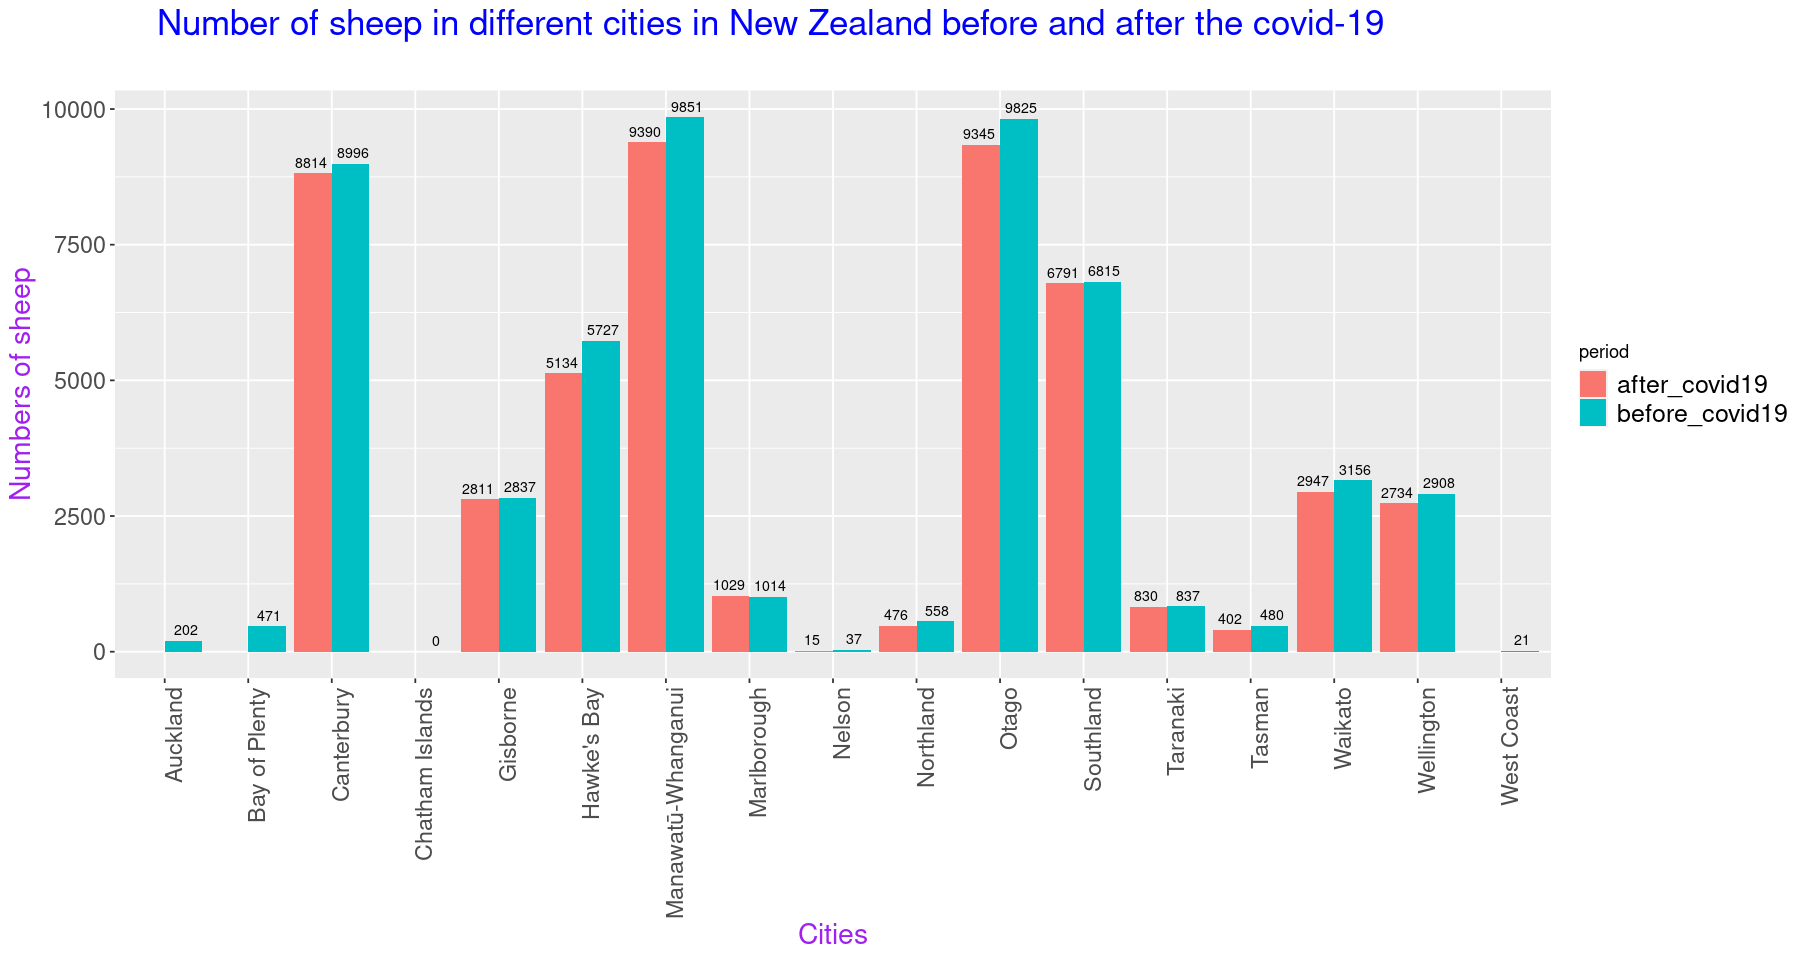

In [140]:
data_sheep_comp_graph <- ggplot(data =compare_before_after_sheep, #Use the data table called 'compare_before_after_sheep'
  mapping = aes(
    x = district, #'district' as the x-axis
    y = number,#'number' as the y-axis
    fill = period))+ #filld with 'periods'
geom_col(position = "dodge") + #position is dodge format
ggtitle("Number of sheep in different cities in New Zealand before and after the covid-19
") + # title of the plot
geom_text(aes(label = number),position=position_dodge(width = 1),size = 3,vjust = -0.5)+ #number of the vertical coordinate is displayed on each column
    theme(plot.title = element_text(size=21,hjust=0.2,color= "blue"), # set size,color  of title
        axis.title = element_text(size=17,color = "purple"), # set size,color of x-axis and y-axis title
        axis.text.x = element_text(size=14,angle = 90, # set size of x-axis variable
        hjust = 1
        ),
        axis.text.y = element_text(size=14, # set size of y-axis variable
        hjust = 1
        ),
        legend.text = element_text(size = 15, face = "plain"))+ #set size format of what shows on the top of each column
    xlab("Cities") + # set the x-axis title
    ylab("Numbers of sheep")  #set the y-axis title 
data_sheep_comp_graph

#### Data and graph on the number of cow before and after the outbreak

> Create two tables on the number of cows, one for the total number of cows before the outbreak and one for the total number of cows after the outbreak, and finally merge the two tables using rbind and create a ggplot graph.

In [141]:
data_cow_before_covid <- livestock_2018_1[,c(1,4,5)] # Select the region column and the number of cow_cattles columns in table ‘livestock_2018_1’
data_cow_before_covid <- data_cow_before_covid %>% slice(-10,-19,-20) 
# Remove the total number of cow_cattles in the North Island and the total number of cow_cattles in the South Island and the total number of cow_cattles in whole New Zealand for each year
colnames(data_cow_before_covid) <- (c("district", "cow2018","cow2019")) #rename for the data table 

In [142]:
#Use mutate to add new column called "period" and which contains "before_covid19"
#Column "number" is number of cow_cattles in 2018 + number of cow_cattles in 2019
#Use select to delete the columns which we don't use 
data_cow_before_covid<-mutate(data_cow_before_covid, number =cow2018+cow2019, period = "before_covid19") %>%
    select(-cow2018,-cow2019)

In [143]:
data_cow_after_covid <- livestock_2020_1[,c(1,4,5)] #Select the columns which are about numbers of cow_cattles in data table 'livestock_2020_1'
data_cow_after_covid <- data_cow_after_covid %>% slice(-10,-19,-20) #remove the rows about southern land,northern land and whole New Zealand total number on cow_cattles
colnames(data_cow_after_covid) <- (c("district", "cow2020","cow2021")) #rename the new table with column names

In [144]:
#Use mutate to add new column called "period" and which contains "after_covid19"
#Column "number" is number of cow_cattles in 2020 + number of cow_cattles in 2021
#Delete the columns which we don't need 
data_cow_after_covid<-mutate(data_cow_after_covid, number =cow2020+cow2021, period = "after_covid19") %>%
    select(-cow2020,-cow2021)

In [145]:
#Use rbind to combine two tables about cow_cattles numbers on different time period
compare_before_after_cow =rbind(data_cow_after_covid,data_cow_before_covid)

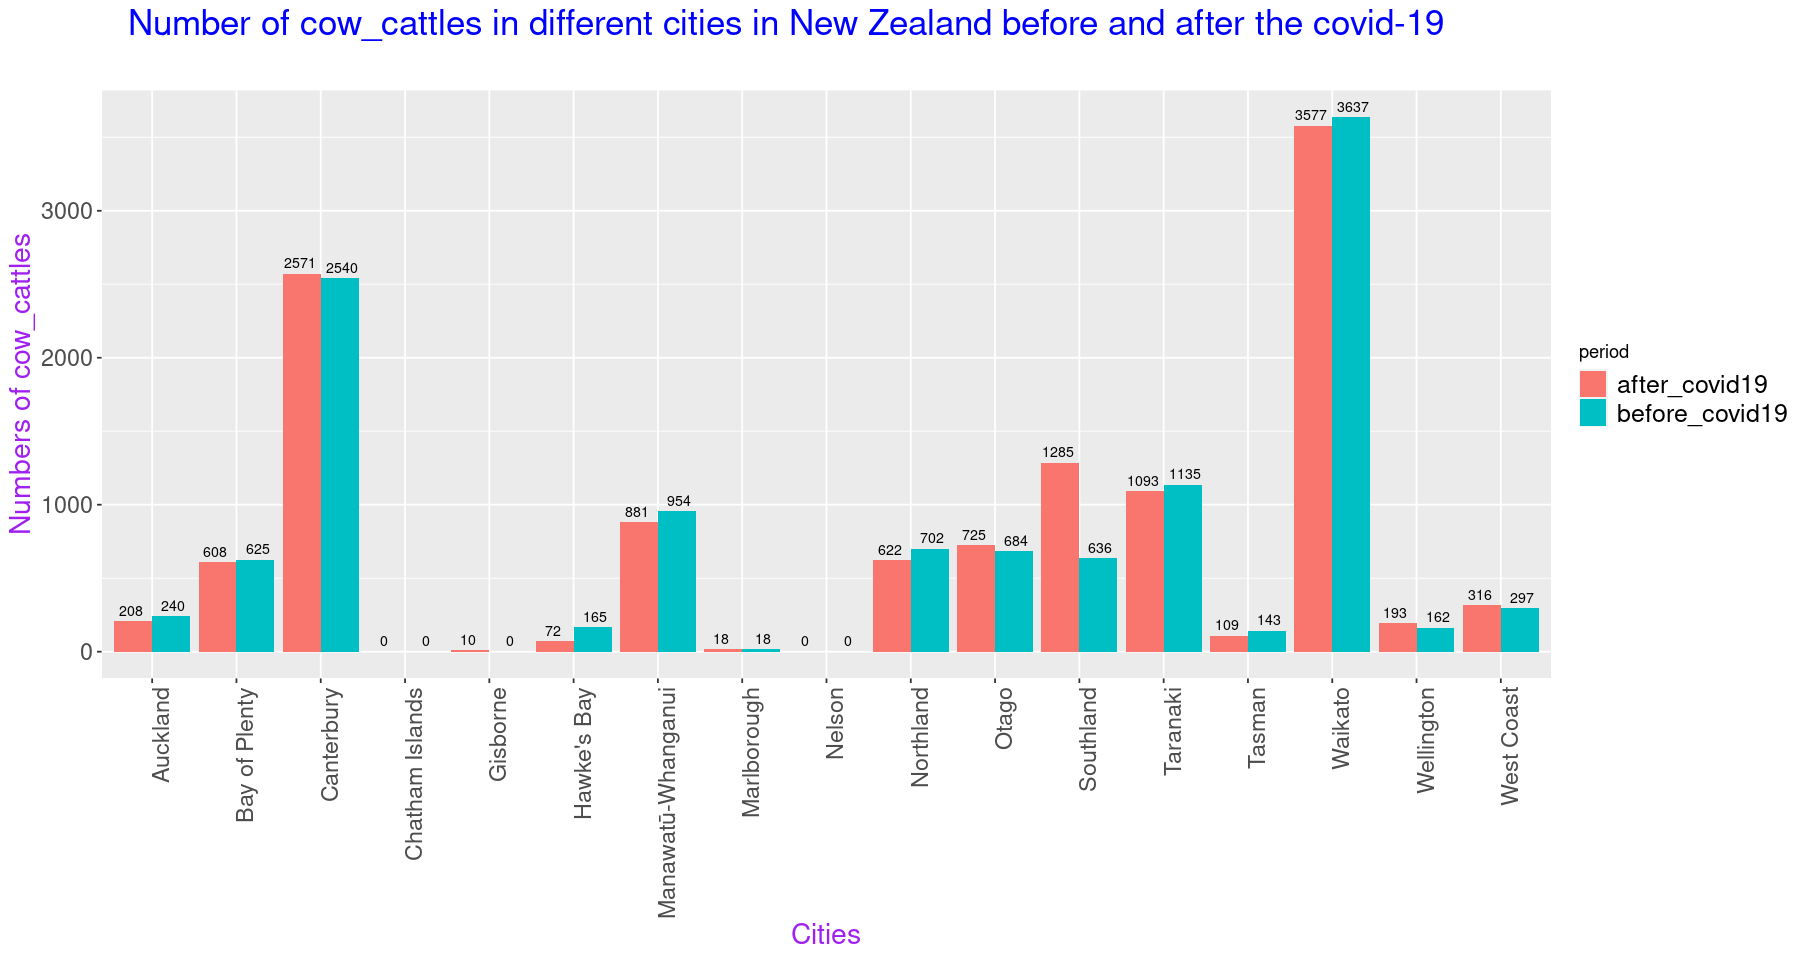

In [146]:
data_cow_comp_graph <- ggplot(data =compare_before_after_cow,#Use the data table called 'compare_before_after_cow'
  mapping = aes(
    x = district, #'district' as the x-axis
    y = number,#'number' as the y-axis
    fill = period)) + #filld with 'periods'
  geom_col(position = "dodge") + #position is dodge format
ggtitle("Number of cow_cattles in different cities in New Zealand before and after the covid-19
") + # title of the plot
geom_text(aes(label = number),position=position_dodge(width = 1),size = 3,vjust = -0.5)+ #number of the vertical coordinate is displayed on each column
    theme(plot.title = element_text(size=21,hjust=0.2,color= "blue"), # set size, color of title
        axis.title = element_text(size=17,color = "purple"), # set size,color of x-axis and y-axis title
        axis.text.x = element_text(size=14,angle = 90, # set size,angle of x-axis variable
        hjust = 1
        ),
        axis.text.y = element_text(size=14, # set size of x-axis variable
        hjust = 1
        ),
        legend.text = element_text(size = 15, face = "plain"))+ #set size format of the text that displayed on columns
    xlab("Cities") + # set the x-axis title
    ylab("Numbers of cow_cattles") # set the y-axis title
data_cow_comp_graph

#### Data and graph on the number of beef before and after the outbreak

> Create two tables on the number of beef, one for the total number of beef before the outbreak and one for the total number of beef after the outbreak, and finally merge the two tables using rbind and create a ggplot graph.

In [147]:
data_beef_before_covid <- livestock_2018_1[,c(1,6,7)] # Select the region column and the number of beefs columns in table ‘livestock_2018_1’
data_beef_before_covid <- data_beef_before_covid %>% slice(-10,-19,-20)
# Remove the total number of beefs in the North Island and the total number of beefs in the South Island and the total number of beefs in New Zealand each year
colnames(data_beef_before_covid) <- (c("district", "beef2018","beef2019")) #rename for the data table 

In [148]:
#Use mutate to add new column called "period" and which contains "before_covid19"
#Column "number" is number of beefs in 2018 + number of beef in 2019

#Use select to delete the columns which we don't use 
data_beef_before_covid<-mutate(data_beef_before_covid, number =beef2018+beef2019, period = "before_covid19") %>%
    select(-beef2018,-beef2019)

In [149]:
data_beef_after_covid <- livestock_2020_1[,c(1,6,7)]  #Select the columns which are about numbers of beefs in data table 'livestock_2020_1'
data_beef_after_covid <- data_beef_after_covid %>% slice(-10,-19,-20)  #remove the rows about southern land,northern land and whole New Zealand total number on beefs
colnames(data_beef_after_covid) <- (c("district", "beef2020","beef2021"))  #rename the new table with column names

In [150]:
#Use mutate to add new column called "period" and which contains "after_covid19"
#Column "number" is number of beefs in 2020 + number of beefs in 2021
#Delete the columns which I don't use for 
data_beef_after_covid<-mutate(data_beef_after_covid, number =beef2020+beef2021, period = "after_covid19") %>%
    select(-beef2020,-beef2021)

In [151]:
#Use rbind to combine two tables about beefs number on different time period
compare_before_after_beef =rbind(data_beef_after_covid,data_beef_before_covid)

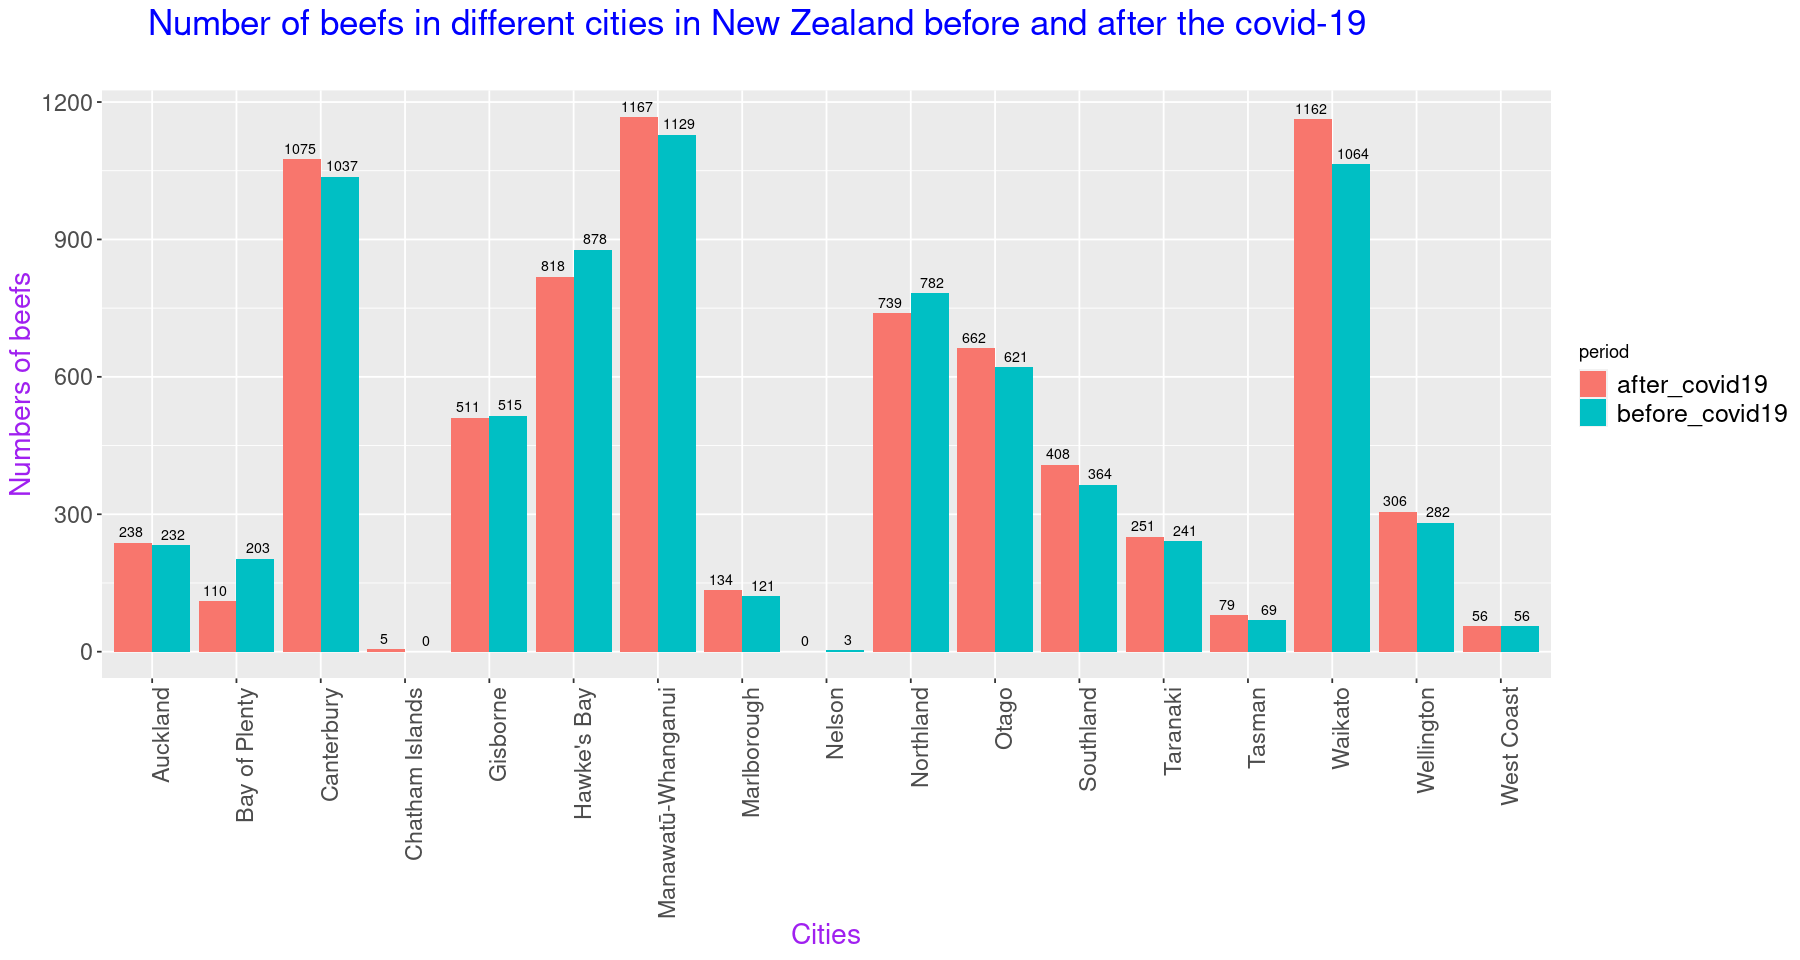

In [152]:
data_beef_comp_graph <- ggplot(data =compare_before_after_beef,#Use the data table called 'compare_before_after_beefs'
  mapping = aes(
    x = district, #'district' as the x-axis
    y = number,#'number' as the y-axis
    fill = period))+#filld with 'periods'
geom_col(position = "dodge") +  #position is dodge format
ggtitle("Number of beefs in different cities in New Zealand before and after the covid-19
") + # title of the plot
geom_text(aes(label = number),position=position_dodge(width = 1),size = 3,vjust = -0.5)+ #number of the vertical coordinate is displayed on each column
    theme(plot.title = element_text(size=21,hjust=0.2,color= "blue"), # set size, color of title
        axis.title = element_text(size=17,color = "purple"),  # set size,color of x-axis and y-axis title
        axis.text.x = element_text(size=14,angle = 90, # set size,angle of x-axis variable
        hjust = 1
        ),
        axis.text.y = element_text(size=14, # set size of x-axis variable
        hjust = 1
        ),
        legend.text = element_text(size = 15, face = "plain"))+ #set size format of the text that displayed on columns
    xlab("Cities") + # set the x-axis title
    ylab("Numbers of beefs")  # set the y-axis title
data_beef_comp_graph

#### Data and graph on the number of deer before and after the outbreak

> Create two tables on the number of deer, one for the total number of deer before the outbreak and one for the total number of deer after the outbreak, and finally merge the two tables using rbind and create a ggplot graph.

In [153]:
data_deer_before_covid <- livestock_2018_1[,c(1,8,9)] # Select the region column and the number of deer columns in table ‘livestock_2018_1’
data_deer_before_covid <- data_deer_before_covid %>% slice(-10,-19,-20) # Remove the total number of deer in the North Island and the total number of deer in the South Island and the total number of deer in New Zealand each year
colnames(data_deer_before_covid) <- (c("district", "deer2018","deer2019")) #rename for the data table 

In [154]:
#Use mutate to add new column called "period" and which contains "before_covid19"
#Column "number" is number of deer in 2018 + number of deer in 2019

#Use select to delete the columns which we don't use 
data_deer_before_covid<-mutate(data_deer_before_covid, number =deer2018+deer2019, period = "before_covid19") %>%
    select(-deer2018,-deer2019)

In [155]:
data_deer_after_covid <- livestock_2020_1[,c(1,8,9)]  #Select the columns which are about numbers of deer in data table 'livestock_2020_1'
data_deer_after_covid <- data_deer_after_covid %>% slice(-10,-19,-20) #remove the rows about southern land,northern land and whole New Zealand total number on deer
colnames(data_deer_after_covid) <- (c("district", "deer2020","deer2021")) #rename the new table with column names

In [156]:
#Use mutate to add new column called "period" and which contains "after_covid19"
#Column "number" is number of deer in 2020 + number of deer in 2021
#Delete the columns which we don't use 
data_deer_after_covid<-mutate(data_deer_after_covid, number =deer2020+deer2021, period = "after_covid19") %>%
    select(-deer2020,-deer2021)

In [157]:
compare_before_after_deer =rbind(data_deer_after_covid,data_deer_before_covid)
#Use rbind to combine two tables about deer number on different time period

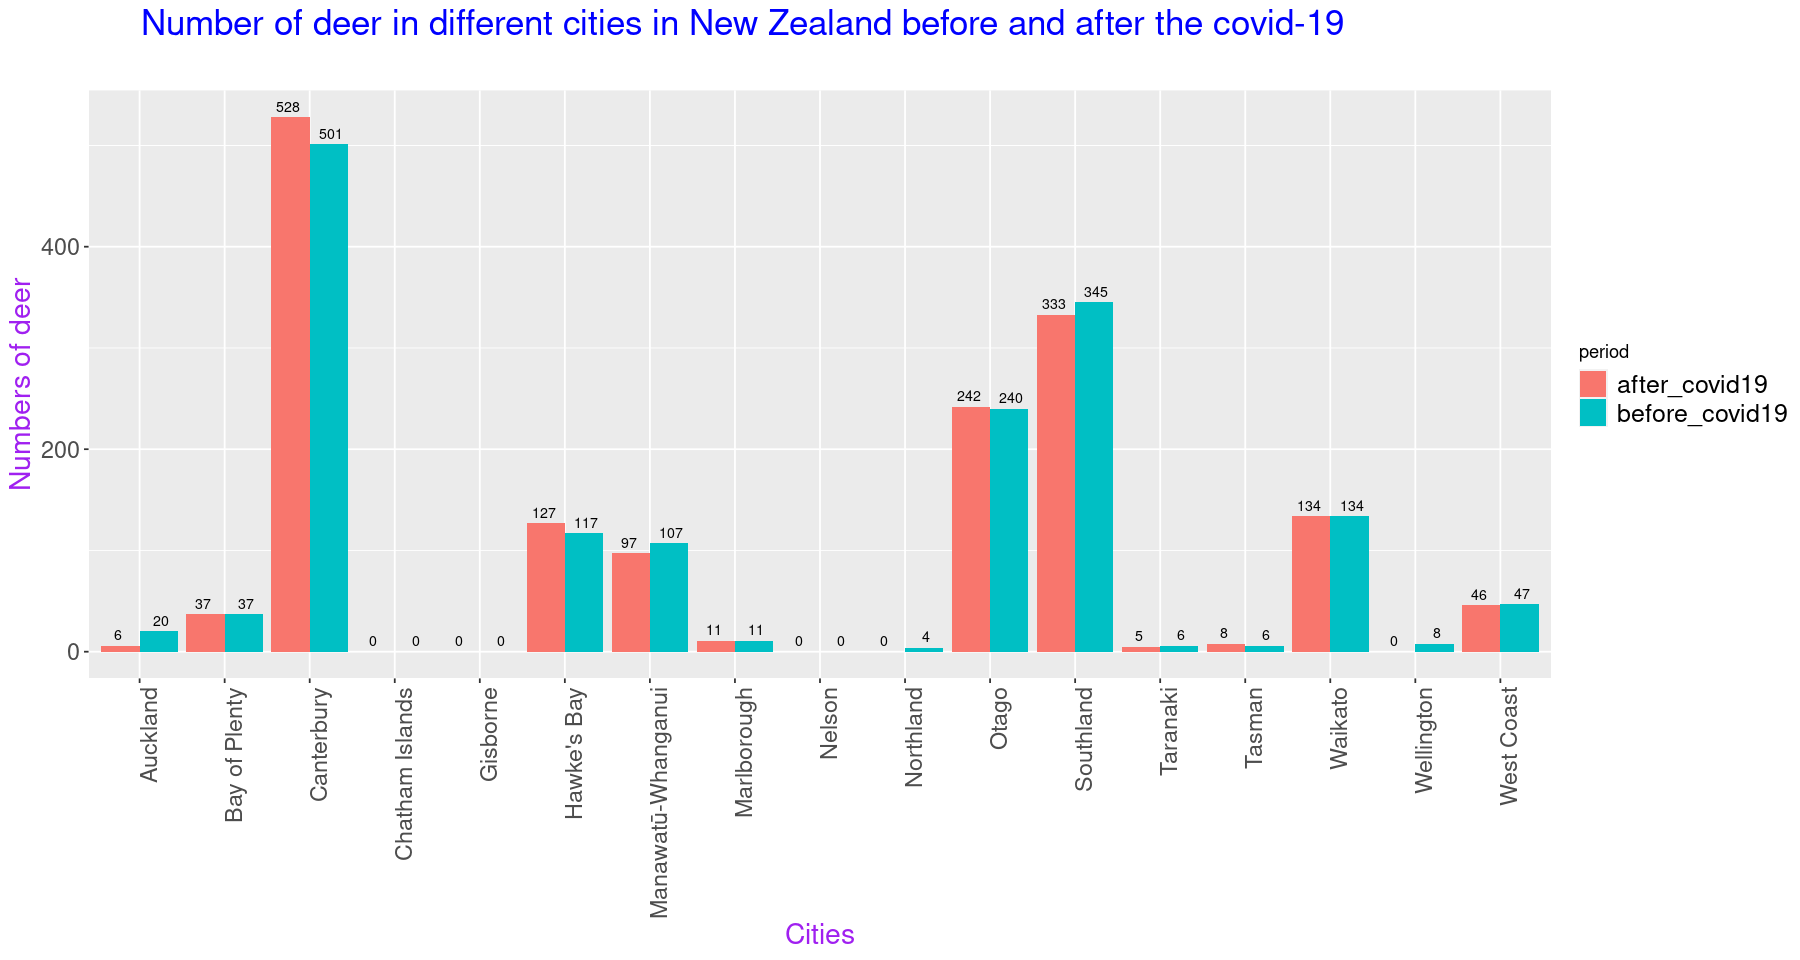

In [158]:
data_deer_comp_graph <- ggplot(data =compare_before_after_deer, #Use the data table called 'compare_before_after_deer'
  mapping = aes(
    x = district, #'district' as the x-axis
    y = number,#'number' as the y-axis
    fill = period)) + #filld with 'periods'
geom_col(position = "dodge") +  #position is dodge format
ggtitle("Number of deer in different cities in New Zealand before and after the covid-19
") + # title of the plot
geom_text(aes(label = number),position=position_dodge(width = 1),size = 3,vjust = -0.5)+ #number of the vertical coordinate is displayed on each column
    theme(plot.title = element_text(size=21,hjust=0.2,color= "blue"), # set size, color of title
        axis.title = element_text(size=17,color = "purple"),# set size,color of x-axis and y-axis title
        axis.text.x = element_text(size=14,angle = 90, # set size,angle of x-axis variable
        hjust = 1
        ),
        axis.text.y = element_text(size=14, # set size of x-axis variable
        hjust = 1
        ),
        legend.text = element_text(size = 15, face = "plain"))+ #set size format of the text that displayed on columns
    xlab("Cities") + # set the x-axis title
    ylab("Numbers of deer") # set the y-axis title
data_deer_comp_graph

### Combine graphs of four spicies together

In [159]:
options(repr.plot.width=30, repr.plot.height=15)

Warning message:
“Removed 4 rows containing missing values (geom_col).”
Warning message:
“Removed 4 rows containing missing values (geom_text).”


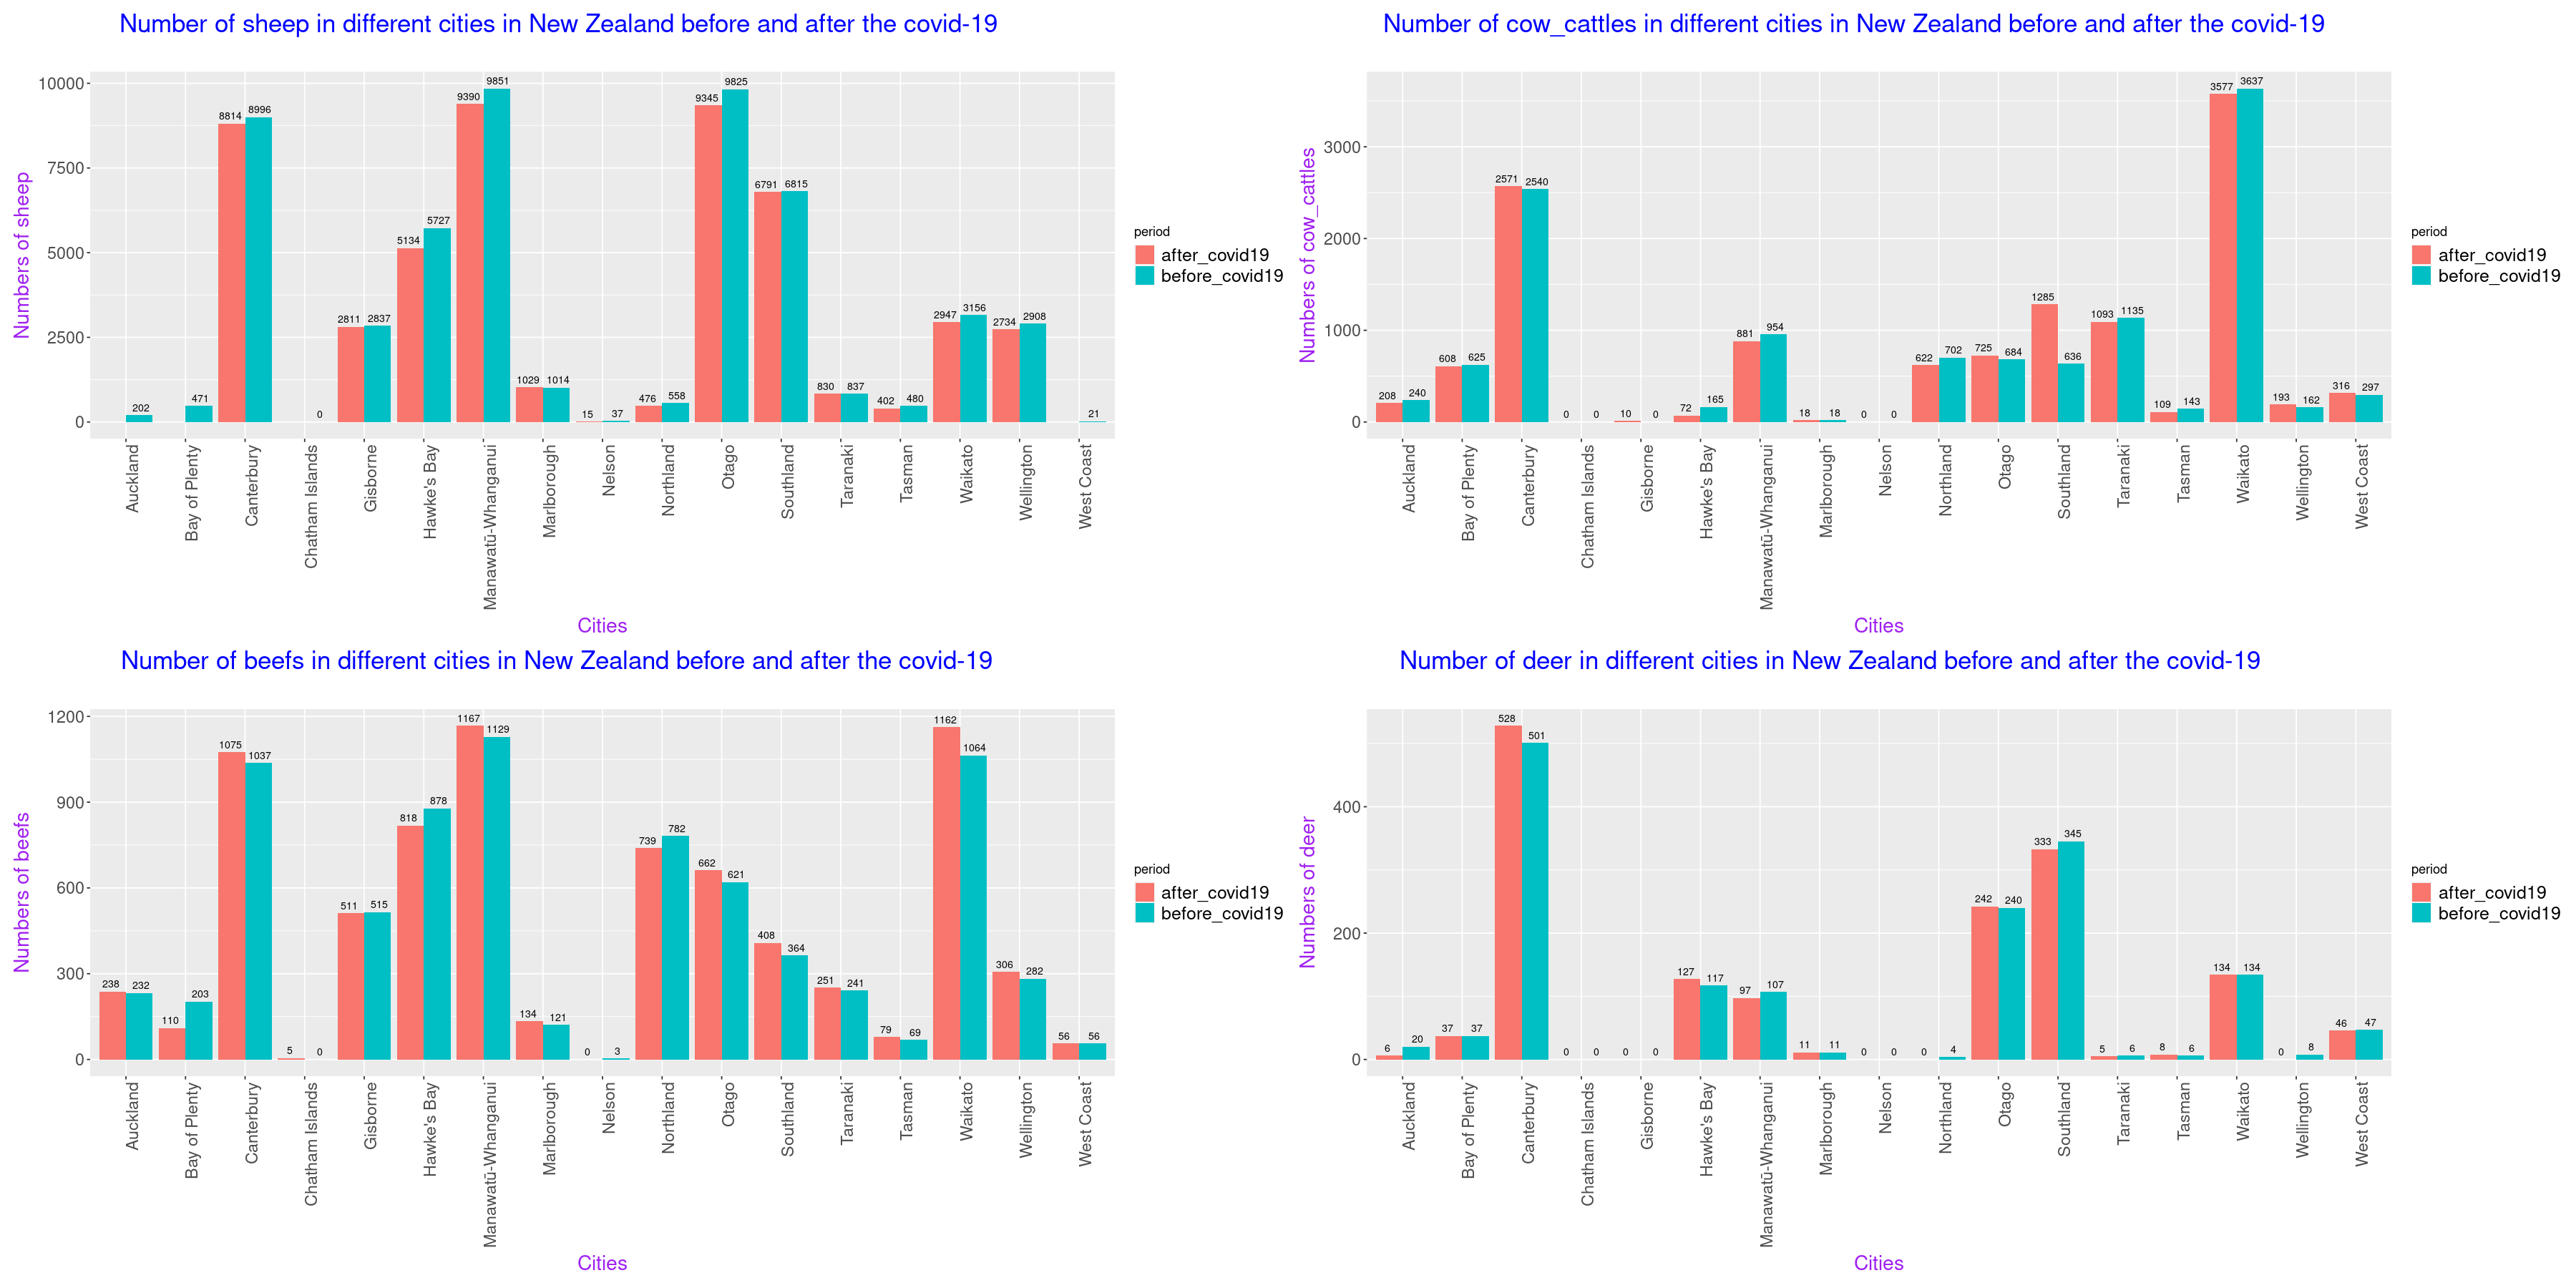

In [160]:
all_livestock_graphs<-data_sheep_comp_graph + data_cow_comp_graph + data_beef_comp_graph + data_deer_comp_graph
all_livestock_graphs

## Effects of Covid on Economy in New Zealand

> In order to analyse the impact of the covid-19 on the economy, I analyse gross domestic product by industry from 2020 to 2022. I use two csv table, they are quarterly values of GDP and quarterly percentage changes of GDP**

In [161]:
options(repr.plot.width=15, repr.plot.height=8)

**Comments: analyse quarterly values**

1. Read the first table about GDP quarterly values

In [162]:
# GDP
gdp_df <- read.csv('Data/GDP_quarterly_values.csv')

2. Only show records from 2020 to 2022, remove unnecessary columns to make the table look cleaner.

In [163]:
gdp_year <- gdp_df %>%
slice(132:141) %>% #choose row from 2020 to 2022
select(-X, -X.1, -X.2, -X.3, -X.4, -X.5, -X.6, -X.7, -X.8, -X.9, -X.10, -X.11, -X.12, -X.13, -X.14, -X.15, -X.16, -X.17, -X.18, -X.19, -X.20, -X.21, -X.22, -X.23, -X.24, -X.25, -X.26, -X.27, -X.28, -X.29, -X.30, -X.31, -X.32, -X.33, -X.34)
#delete unnecessary columns

3. Select the columns which I need. Year, month, agriculture, health, and combined gdp, then fill in the missing years

In [164]:
gdp_compare <- gdp_year %>%
select(Year, Month, Gross.domestic.product, Agriculture, Health.care.and.social.assistance) %>% #select columns which needed
rename(gdp=Gross.domestic.product, Health=Health.care.and.social.assistance) %>% #change the columns name for clear table
na.locf() #fill in NA

4. Integrate year and month together for easy graphing of quarterly gdp changes. In order to make the sorting of months more reasonable, set the integrated Time as factor and sort them.

In [165]:
gdp_change <- gdp_compare %>%
unite(Time, Year, Month, sep=":") #merge year and month, show title time
gdp_change$Time <- factor(gdp_change$Time, levels=c("2020:Mar", "2020:Jun", "2020:Sep", "2020:Dec", "2021:Mar", "2021:Jun", "2021:Sep", "2021:Dec", "2022:Mar", "2022:Jun"))
#set the type of time to factor

5. Make a graph that summarizes the quarterly changes in gdp and observe the changes in gdp after the arrival of covid-19.

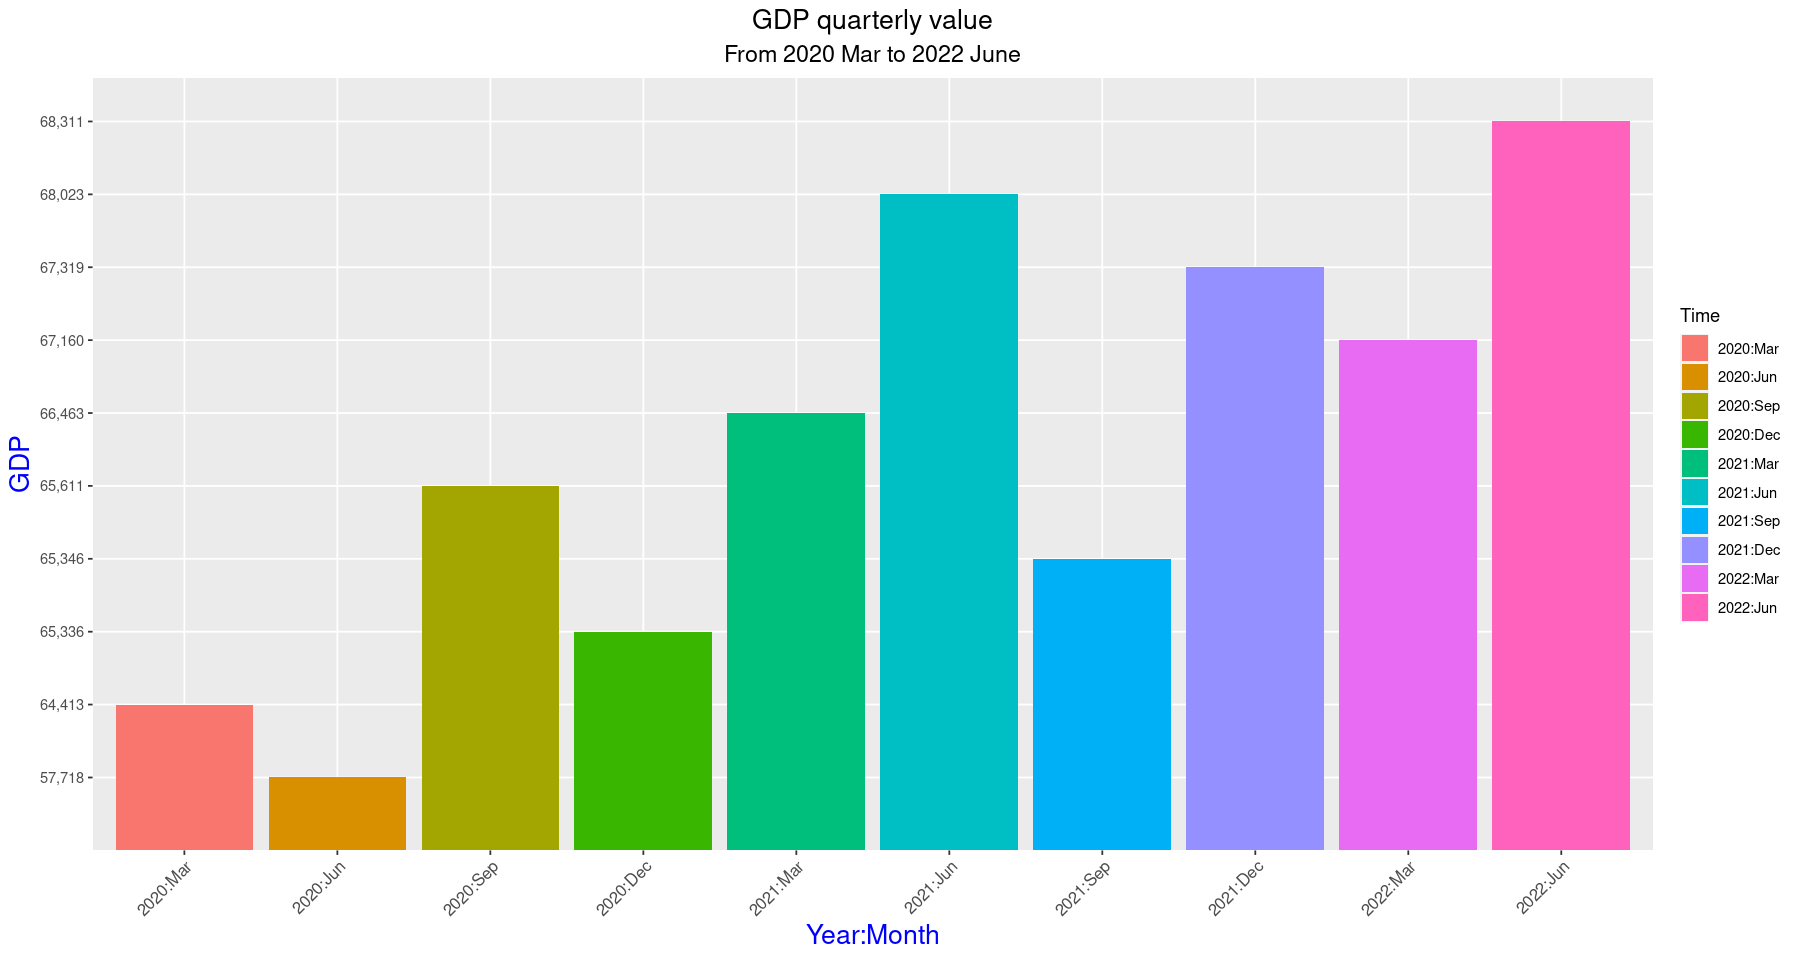

In [166]:
gdp_graph <- gdp_change %>%
ggplot(data=.,mapping = aes(x=Time,y=gdp, fill=Time)) +
geom_col() +
labs(x="Year:Month",
     y="GDP",
     title="GDP quarterly value",
     subtitle="From 2020 Mar to 2022 June"
     ) +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     )
gdp_graph

6. Make a graph that summarizes the quarterly changes in agriculture gdp and observe the changes in agriculture gdp after the arrival of covid-19.

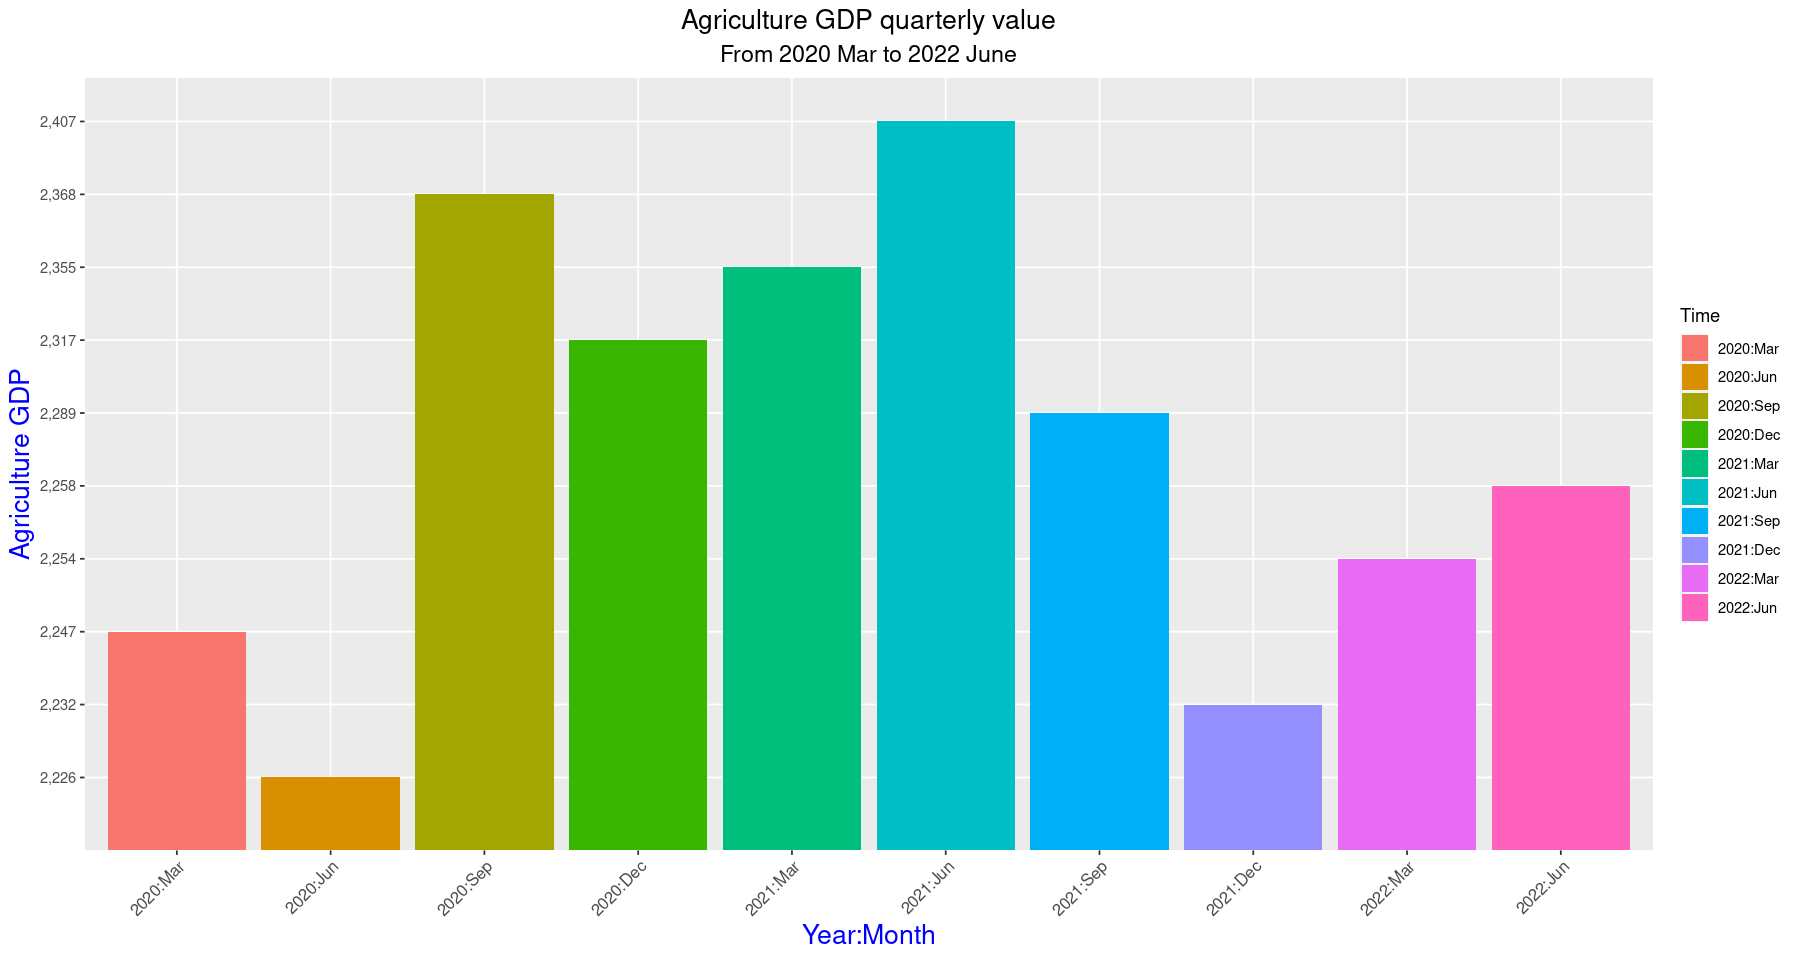

In [167]:
gdp_agri <- gdp_change %>%
ggplot(data=.,mapping = aes(x=Time,y=Agriculture, fill=Time)) +
geom_col() +
labs(x="Year:Month",
     y="Agriculture GDP",
     title="Agriculture GDP quarterly value",
     subtitle="From 2020 Mar to 2022 June"
     ) +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     )
gdp_agri

7. Make a graph that summarizes the quarterly changes in health gdp and observe the changes in health gdp after the arrival of covid-19.

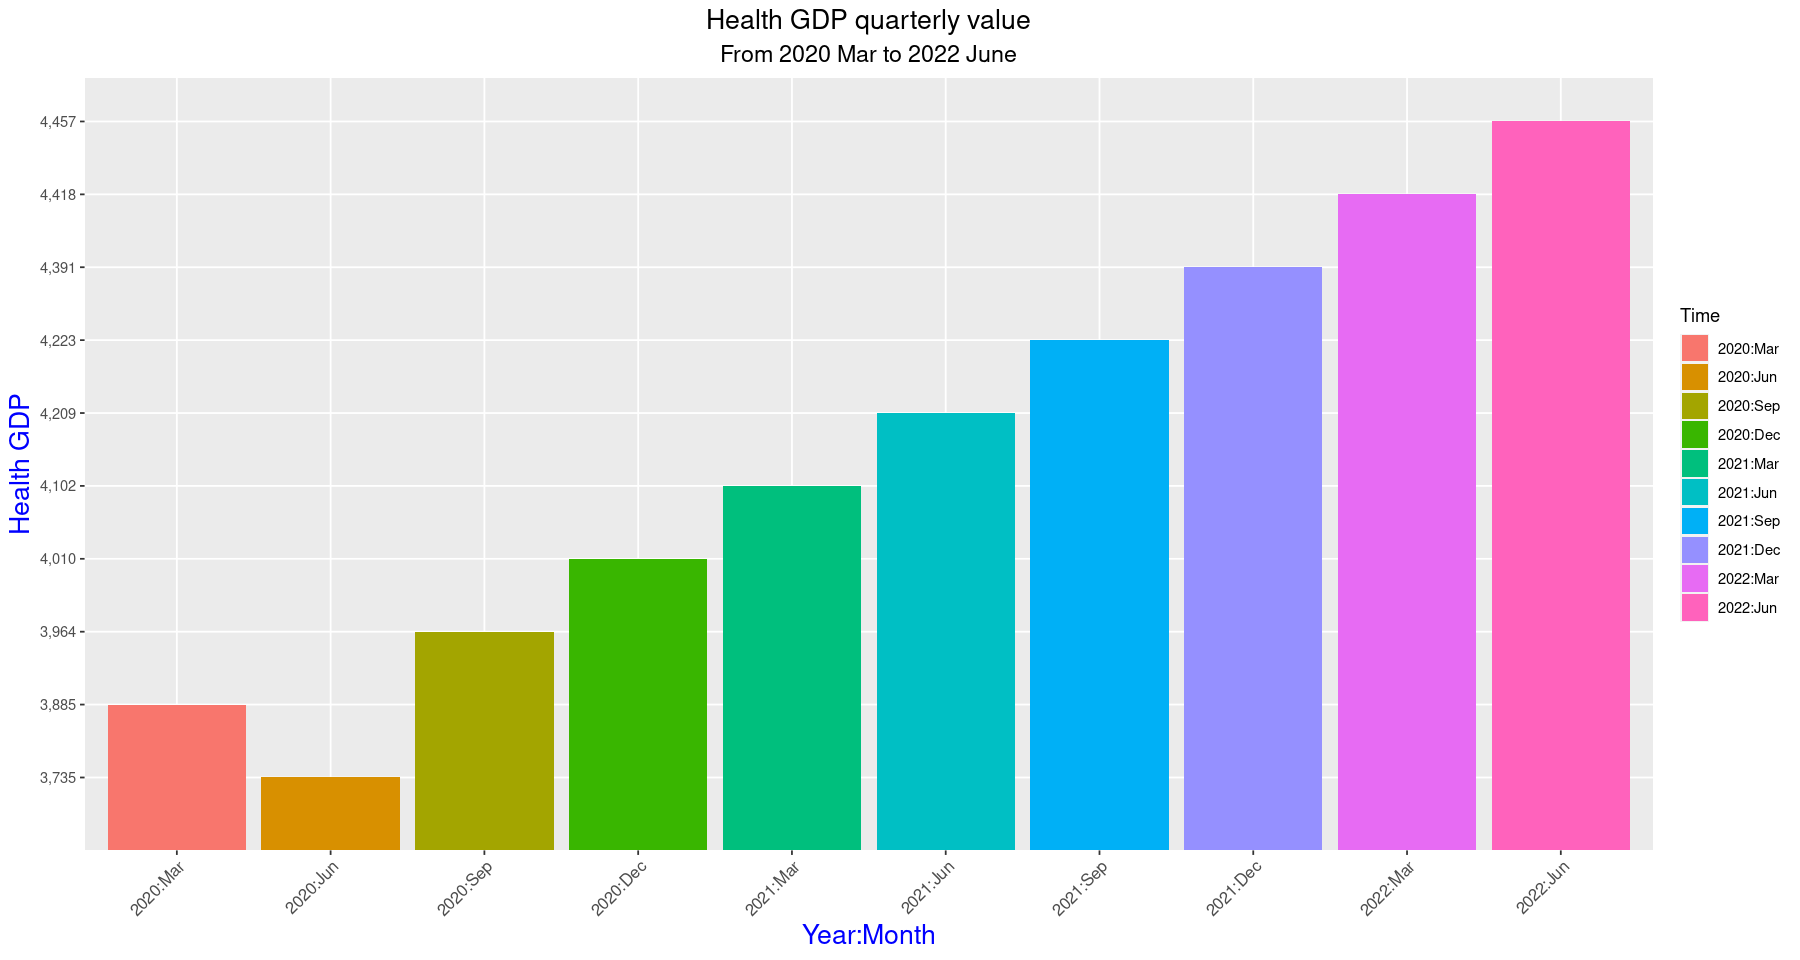

In [168]:
gdp_health <- gdp_change %>%
ggplot(data=.,mapping = aes(x=Time,y=Health, fill=Time)) +
geom_col() +
labs(x="Year:Month",
     y="Health GDP",
     title="Health GDP quarterly value",
     subtitle="From 2020 Mar to 2022 June"
     ) +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     )
gdp_health

**Comments: analyse gdp quarterly percentage change table**

1. Read the second table about GDP quarterly percentage change.

In [169]:
# GDP percentage
percentage_df <- read.csv('Data/GDP_quarterly_percentage_change.csv')

2. Select row from 2020 to 2022, delete unnecessary columns

In [170]:
percentage_year <- percentage_df %>%
slice(132:141) %>% # choose rows from 2020 to 2022
select(-X) # delete empty column

3. Select columns for year, month, combined gdp, agriculture, health. Then fill in the missing years

In [171]:
percenge_compare <- percentage_year %>%
select(Year, Month, Gross.domestic.product, Agriculture, Health.care.and.social.assistance) %>% # choose columns which needed
rename(gdp=Gross.domestic.product, Health=Health.care.and.social.assistance) %>% # change the name of column title for clear table
na.locf() #fill in empty year

4. Because the change has positive and negative values, I want the column in the chart to have positive values above x=0 and negative values below x=0, so I changed the column types of gdp, agriculture, and health to numeric.

In [172]:
percentage_change <- percenge_compare %>%
unite(Time, Year, Month, sep=":") #merge year and month, show title time
percentage_change$Time <- factor(percentage_change$Time, levels=c("2020:Mar", "2020:Jun", "2020:Sep", "2020:Dec", "2021:Mar", "2021:Jun", "2021:Sep", "2021:Dec", "2022:Mar", "2022:Jun"))
#change the type of time to factor as showing level
percentage_change$gdp <- as.numeric(percentage_change$gdp) # change the type of gdp column
percentage_change$Agriculture <- as.numeric(percentage_change$Agriculture) # change the type of Agriculture column
percentage_change$Health <- as.numeric(percentage_change$Health) # change the type of Health column

5. Make a column chart of the percent change in combined gdp seasonality from 2020 to 2022

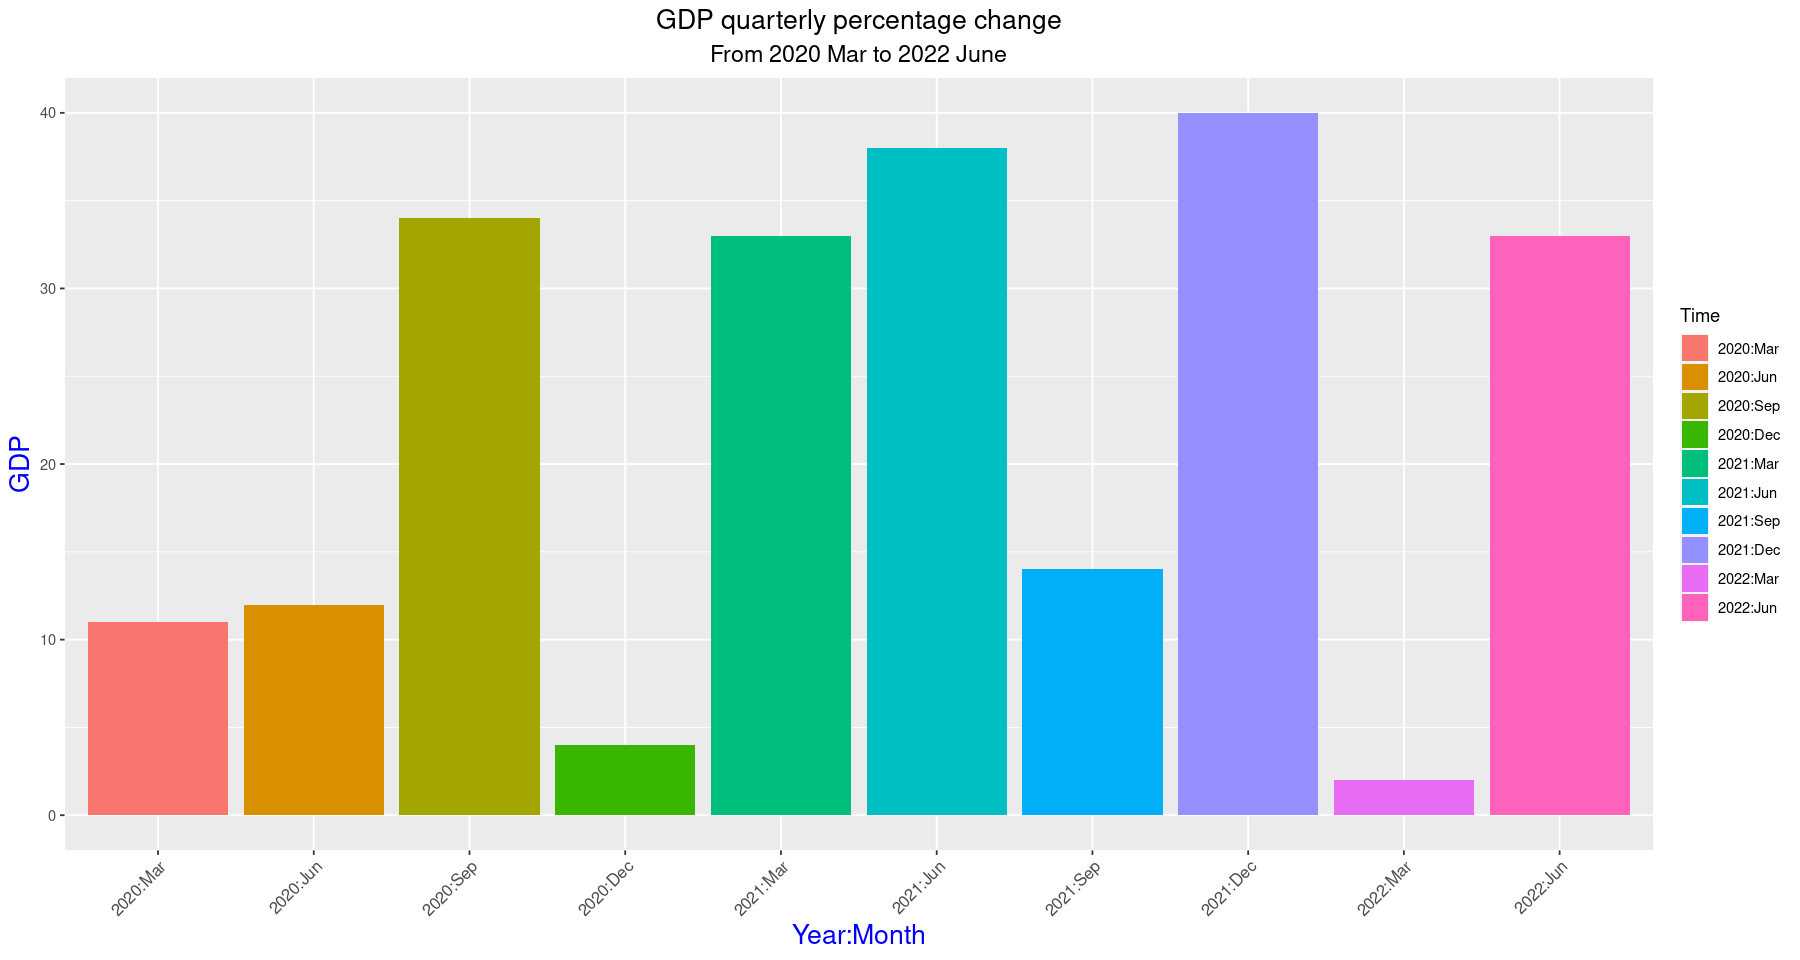

In [173]:
percentage_graph <- percentage_change %>%
ggplot(data=.,mapping = aes(x=Time,y=gdp, fill=Time)) +
geom_col() +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     ) +
labs(x="Year:Month",
     y="GDP",
     title="GDP quarterly percentage change",
     subtitle="From 2020 Mar to 2022 June"
     )
percentage_graph

6. Make a column chart of the percent change in agriculture gdp seasonality from 2020 to 2022

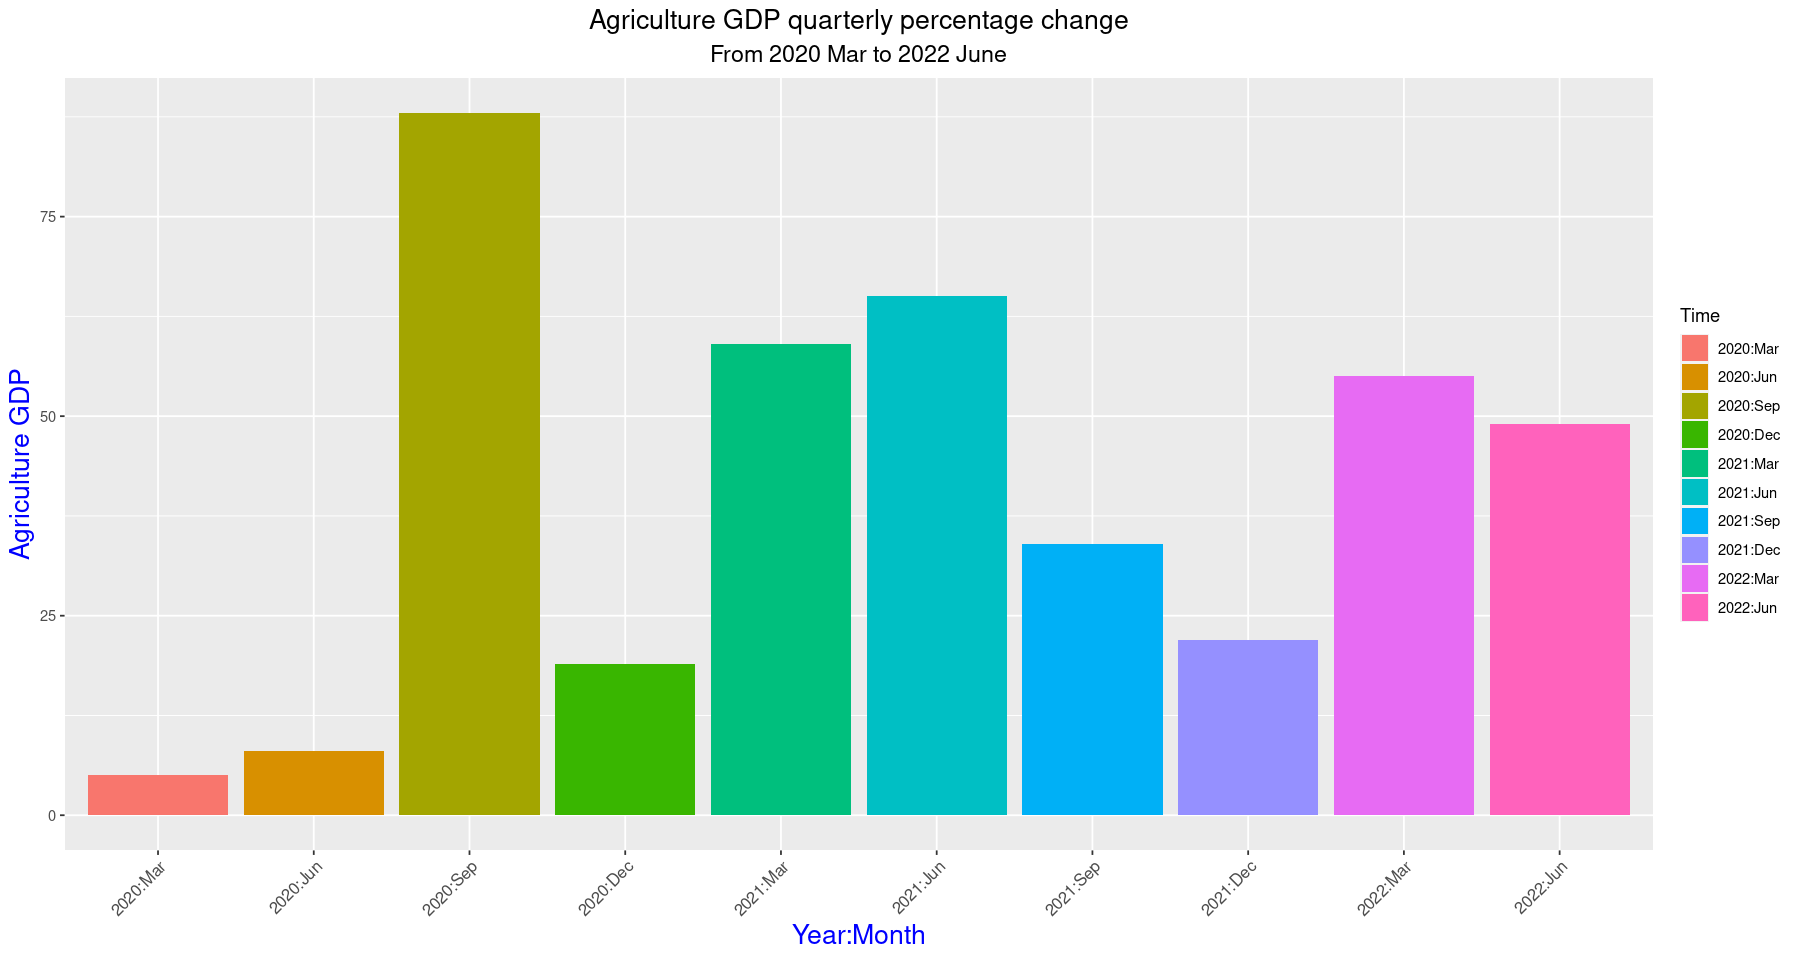

In [174]:
percentage_agriculture <- percentage_change %>%
ggplot(data=.,mapping = aes(x=Time,y=Agriculture, fill=Time)) +
geom_col() +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     ) +
labs(x="Year:Month",
     y="Agriculture GDP",
     title="Agriculture GDP quarterly percentage change",
     subtitle="From 2020 Mar to 2022 June"
     )
percentage_agriculture

7. Make a column chart of the percent change in health gdp seasonality from 2020 to 2022

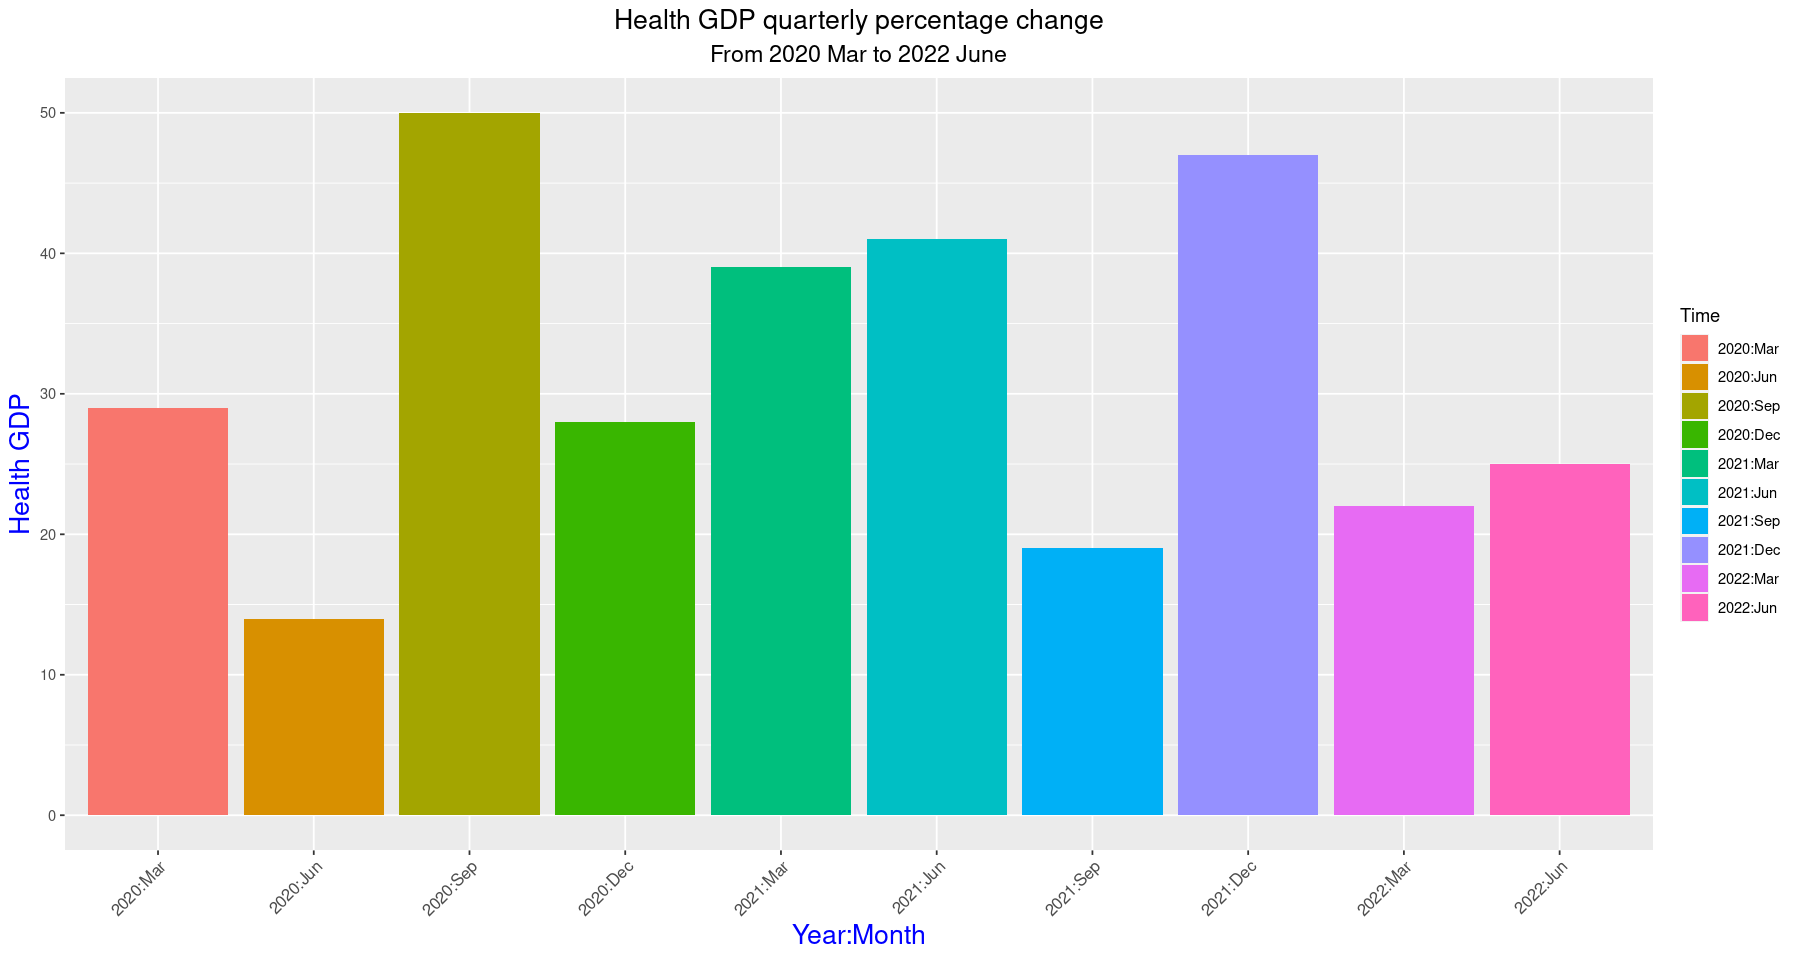

In [175]:
percentage_health <- percentage_change %>%
ggplot(data=.,mapping = aes(x=Time,y=Health, fill=Time)) +
geom_col() +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     ) +
labs(x="Year:Month",
     y="Health GDP",
     title="Health GDP quarterly percentage change",
     subtitle="From 2020 Mar to 2022 June"
     )
percentage_health

**Comments: Combine charts in pairs for easy observation of changes and trends**

1. Merge plots of combined gdp values, Agriculture gdp values and Health gdp values.

In [176]:
gdp_final <- gdp_change %>%
pivot_longer('gdp':'Health', 
             names_to = "Type",
             values_to = "Value") # chanage column to row

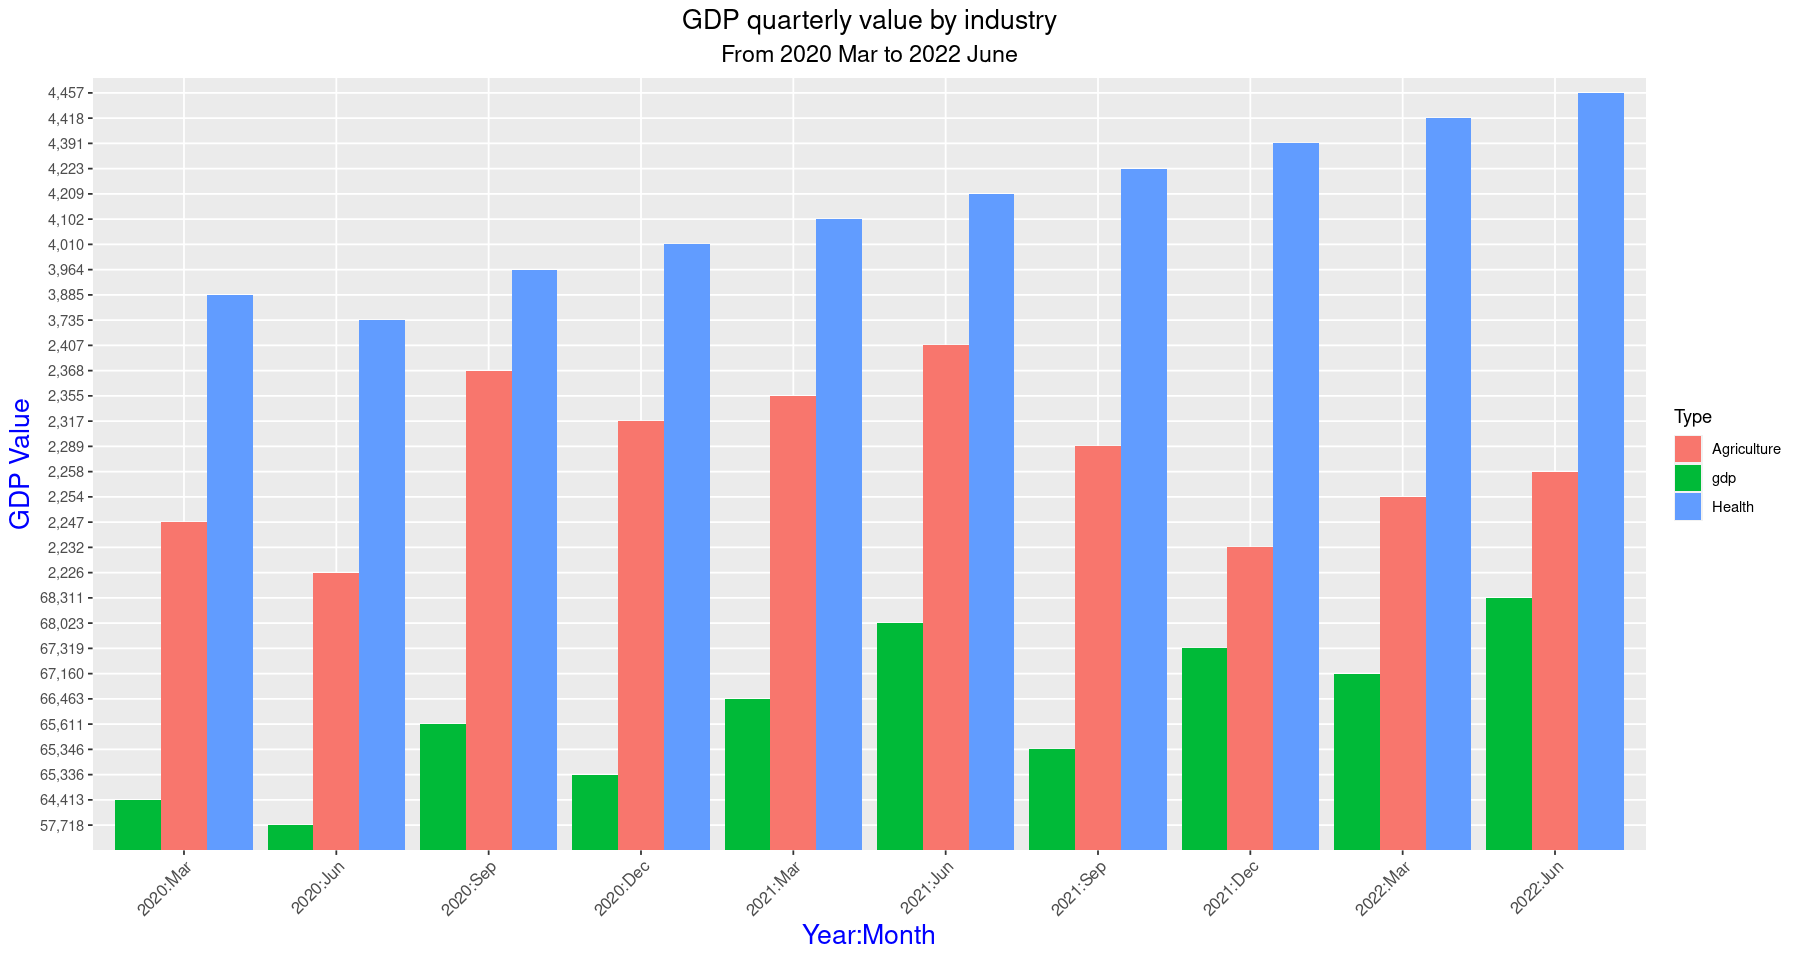

In [177]:
value <- gdp_final %>%
ggplot(data=.,mapping = aes(x=Time,y=Value, fill=Type)) +
geom_col(position="dodge") +
labs(x="Year:Month",
     y="GDP Value",
     title="GDP quarterly value by industry",
     subtitle="From 2020 Mar to 2022 June"
     ) +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     )
value

2. Merge plots of combined gdp percentage changes, Agriculture gdp percentage changes and Health gdp percentage changes.

In [178]:
percentage_final <- percentage_change %>%
pivot_longer('gdp':'Health', 
             names_to = "Type",
             values_to = "Value") # chanage column to row

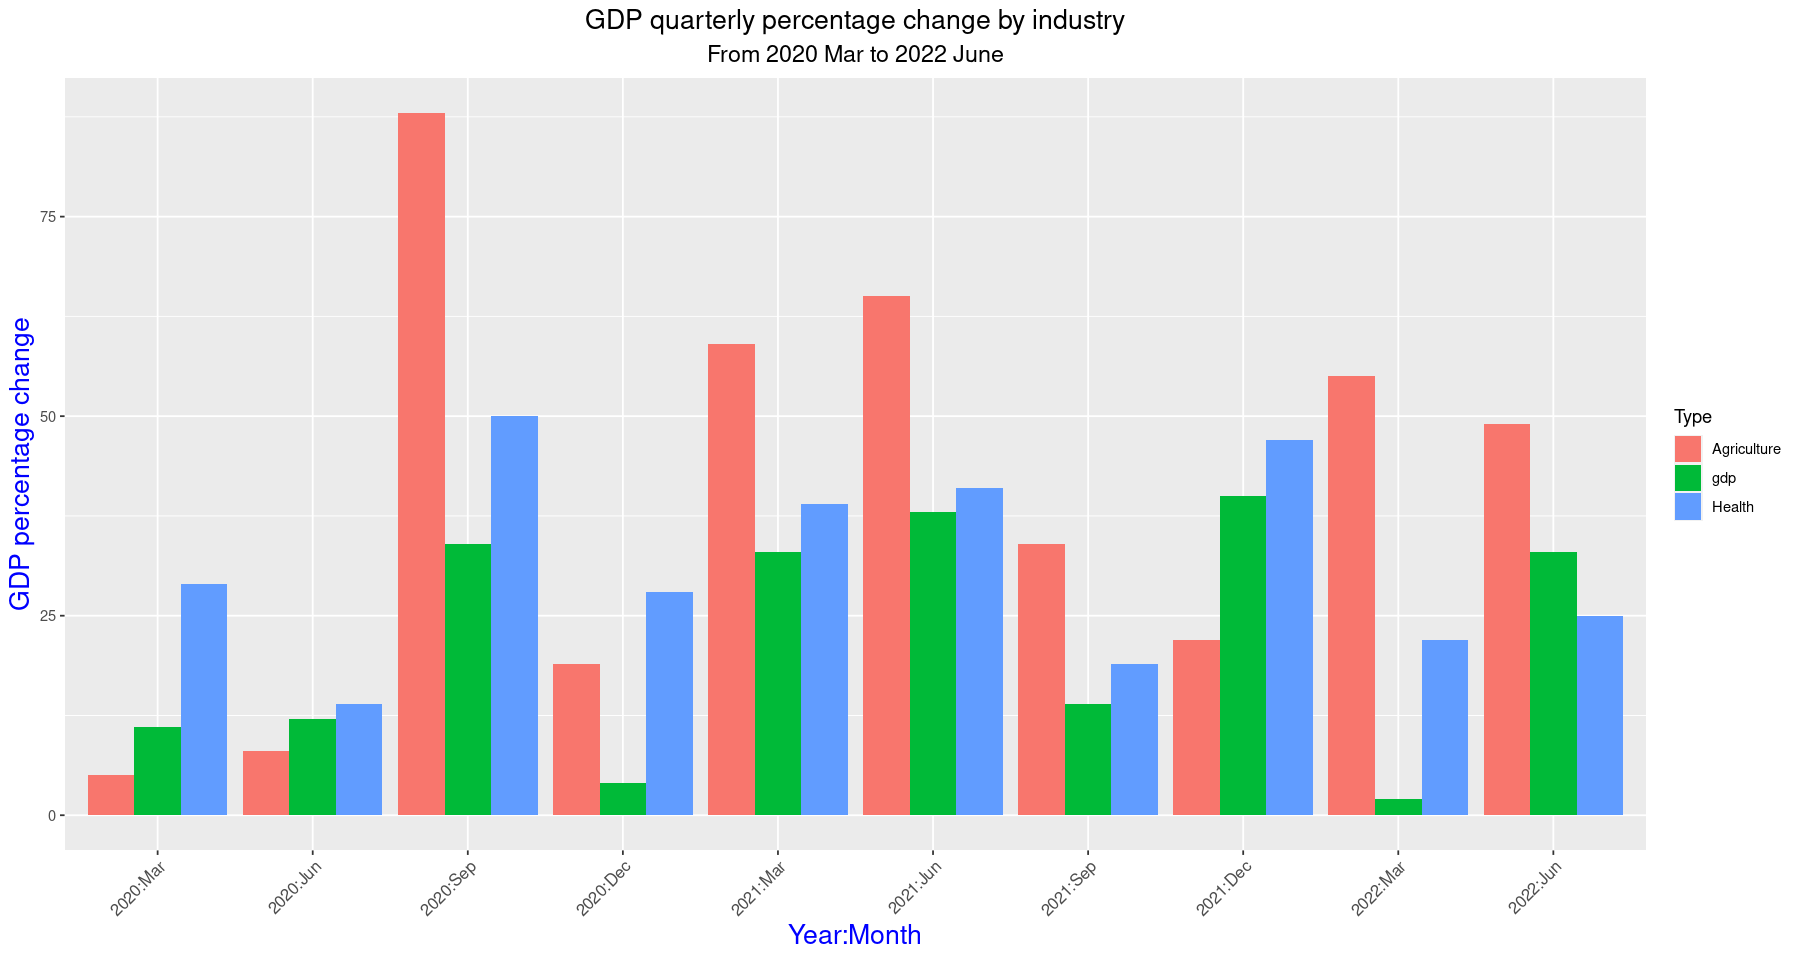

In [179]:
percentage <- percentage_final %>%
ggplot(data=.,mapping = aes(x=Time,y=Value, fill=Type)) +
geom_col(position="dodge") +
labs(x="Year:Month",
     y="GDP percentage change",
     title="GDP quarterly percentage change by industry",
     subtitle="From 2020 Mar to 2022 June"
     ) +
theme(plot.title = element_text(color='black',size=16,hjust=0.5), 
      plot.subtitle = element_text(color='black',size=14,hjust=0.5),
     axis.text.x = element_text(size=10, angle=45, vjust=1, hjust=1),
     axis.title = element_text(size=16, color='blue')
     )
percentage

## Effects of Covid vaccination on the death rate during 2021 in New Zealand

> Covid has caused problems in New Zealand agriculture since outbreak, it's safe to assume that it must has similar impact on the health of New Zealand citizens, which we are going to find out by checking the efficiency of the Covid vaccine during covid period.     

In [180]:
# This will set up graph configuration with width and height
options(repr.plot.width=15, repr.plot.height=8)

#### Get the vaccine cases base on different NZ districts

> 1. Read the vaccine data from webpage and modify it into useable dataframe. Firstly we need to turn the first row as the column names 

In [181]:
# Read vaccine data from html and convert it to readible dataframe
vaccine_data <- read_html("https://github.com/minhealthnz/nz-covid-data/blob/main/vaccine-data/2021-10-19/doses_group_and_dhb_service.csv") %>%
            html_nodes(".js-file-line-container") %>%
            html_table()
vaccine_data %<>% as.data.frame()
colnames(vaccine_data) <- c("filler", "Week ending", "Group", "DHB of service", "Dose number", "# doses administered") 
vaccine_data %<>% select(-"filler") %>% filter(!row_number() == 1)

> 2. Secondly, we need to change the column name for direct reference with "$". Then we need change them into correct data types and filter out the column we need

In [182]:
# Modify column name for later use
colnames(vaccine_data)[1] <- "weekly_date"
colnames(vaccine_data)[3] <- "service"
colnames(vaccine_data)[5] <- "uptake_number"
vaccine_data %<>% select(c("weekly_date", "service", "uptake_number"))
# filter data into what we need
vaccine_data$weekly_date %<>% as.Date()
vaccine_data$uptake_number %<>% as.numeric()
vaccine_data %<>% 
        group_by(weekly_date, service) %>% 
        mutate(total_uptake_number = sum(uptake_number)) %>%
        select(-uptake_number) %>%
        ungroup() %>%
        distinct()

> 3. We realize that the district column is filled with the service center name, we need to convert the data into actual district name. 

In [183]:
# read covid service based on different region
dhb_mapping_data <- read_csv('Data/grouped_dhb_mapping.csv', show_col_types = FALSE)

In [184]:
# Change the column name to something more concise
colnames(dhb_mapping_data)[2] <- "service"
dhb_mapping_data %<>% group_by(service) %>% summarize(all_districts = paste(DHB, collapse = ", "))

> 4. Now merge two table and get the full table ready to be plotted

In [185]:
#change service to actual districts
vaccine_data2 <- vaccine_data %>% left_join(dhb_mapping_data, by="service")
vaccine_data2 %<>% select(-service)
vaccine_data2 %<>% na.omit()

> 5. Now create the plot of vaccine uptake by district

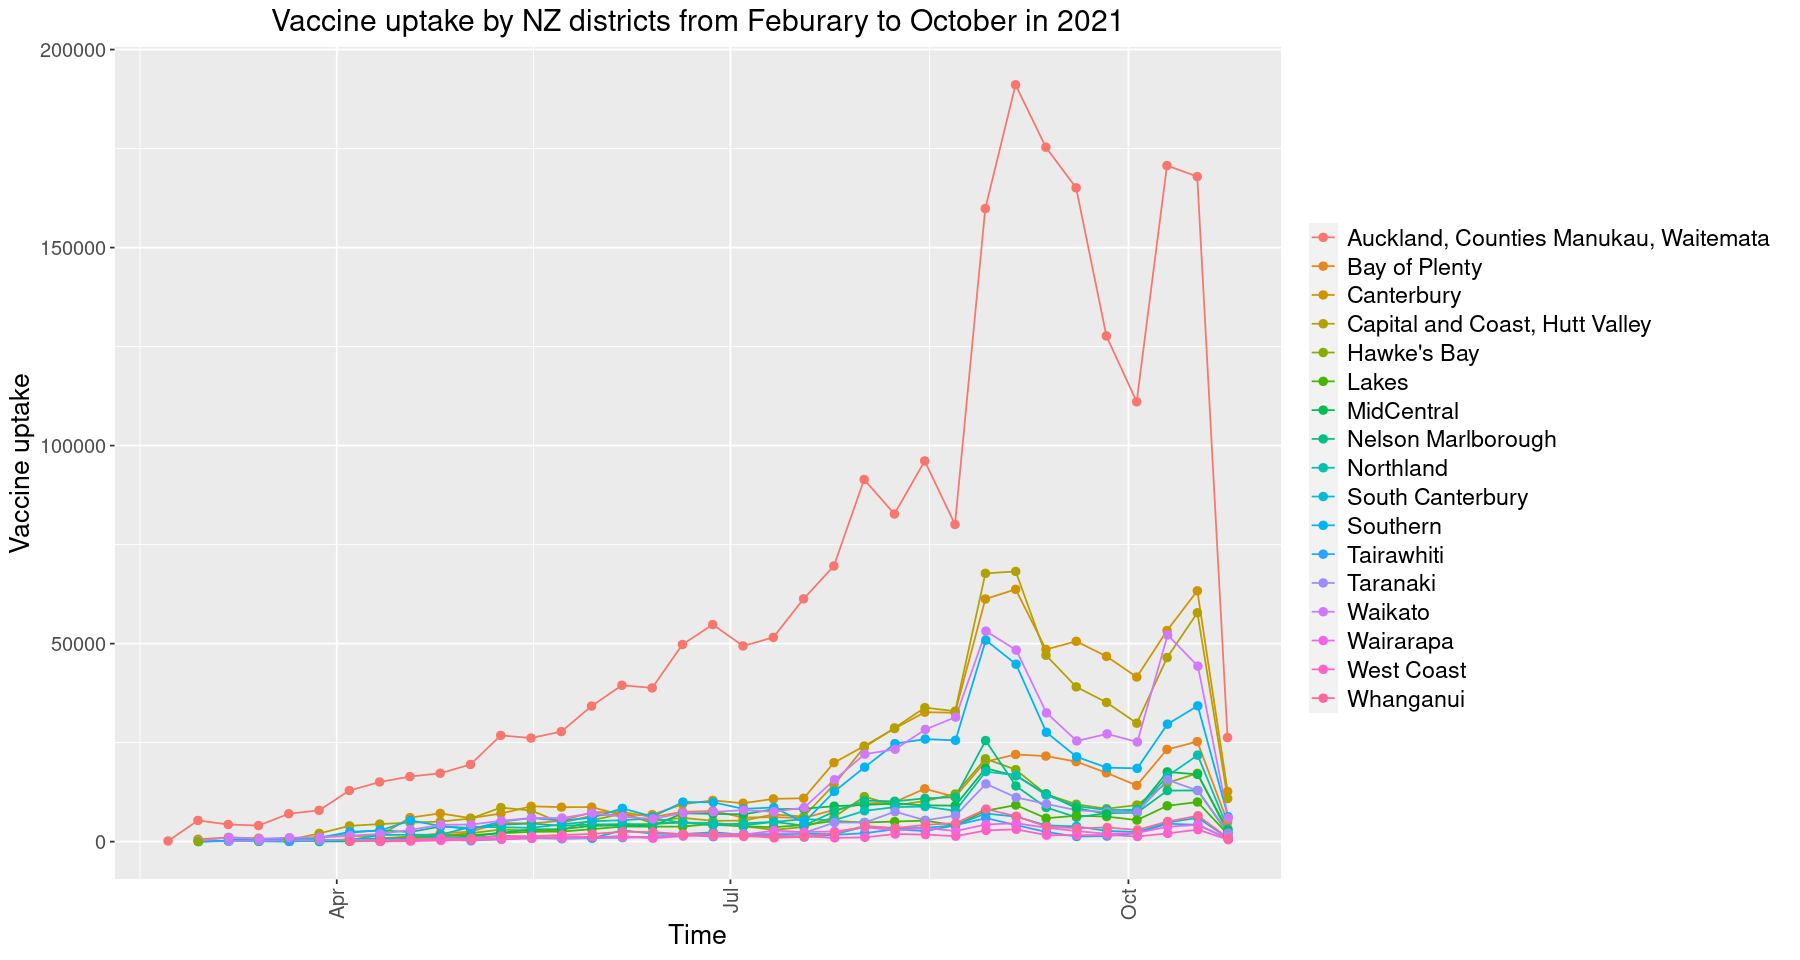

In [186]:
# The vaccine uptake in different districts
vaccine_graph_by_district <- vaccine_data2 %>% 
        ggplot(aes(x=weekly_date, y=total_uptake_number, color=all_districts, group=all_districts)) + 
        ggtitle('Vaccine uptake by NZ districts from Feburary to October in 2021') + 
        geom_line(position = position_dodge(0.2)) +
        geom_point(position = position_dodge(0.2), size=2) +
        # geom_text(aes(label=total_uptake_number), position=position_dodge(width=0.9), vjust=-0.75) +
        theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=16), 
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size=12),
              axis.text.y = element_text(size=12),
              legend.title=element_blank(),
              legend.position = "right", 
              legend.text = element_text(size=14)) + 
        xlab("Time") + ylab("Vaccine uptake")  
vaccine_graph_by_district

#### Combine the test cases and death cases to create a trend graph for better data presenting 

> 1. Modify the summarised test cases daily data into weekly data 

In [187]:
# vaccine test cases
test_case_data1 <- summarise_data_by_date %>% 
        mutate(week = cut.Date(Date, breaks = "1 week", labels = FALSE)) %>% 
        arrange(Date) %>%
        group_by(week) %>%
        summarise(WeeklyCases = sum(total_cases), Week = max(Date)) %>%
        select(Week, WeeklyCases)
test_case_data1 %<>% na.omit()
colnames(test_case_data1)[1] <- "weekly_date"
colnames(test_case_data1)[2] <- "weekly_total_cases"

> 2. merge test cases and vaccine data together, then we only need to add death cases to create plot

In [188]:
# merge test cases table and vaccine data table together 
vac_tes_table <- merge(vaccine_data2, test_case_data1, by="weekly_date")

> 3. read and modify death cases data

In [189]:
# death rate
death_data = read_csv("https://raw.githubusercontent.com/minhealthnz/nz-covid-data/main/cases/weekly-deaths.csv", show_col_types = FALSE)

In [190]:
# change column names so they can be called after $
colnames(death_data)[1] <- "weekly_date"
colnames(death_data)[2] <- "death_in_28_days"
colnames(death_data)[3] <- "death_attributable"

> 4. At last, create the combined graph of test cases and death cases

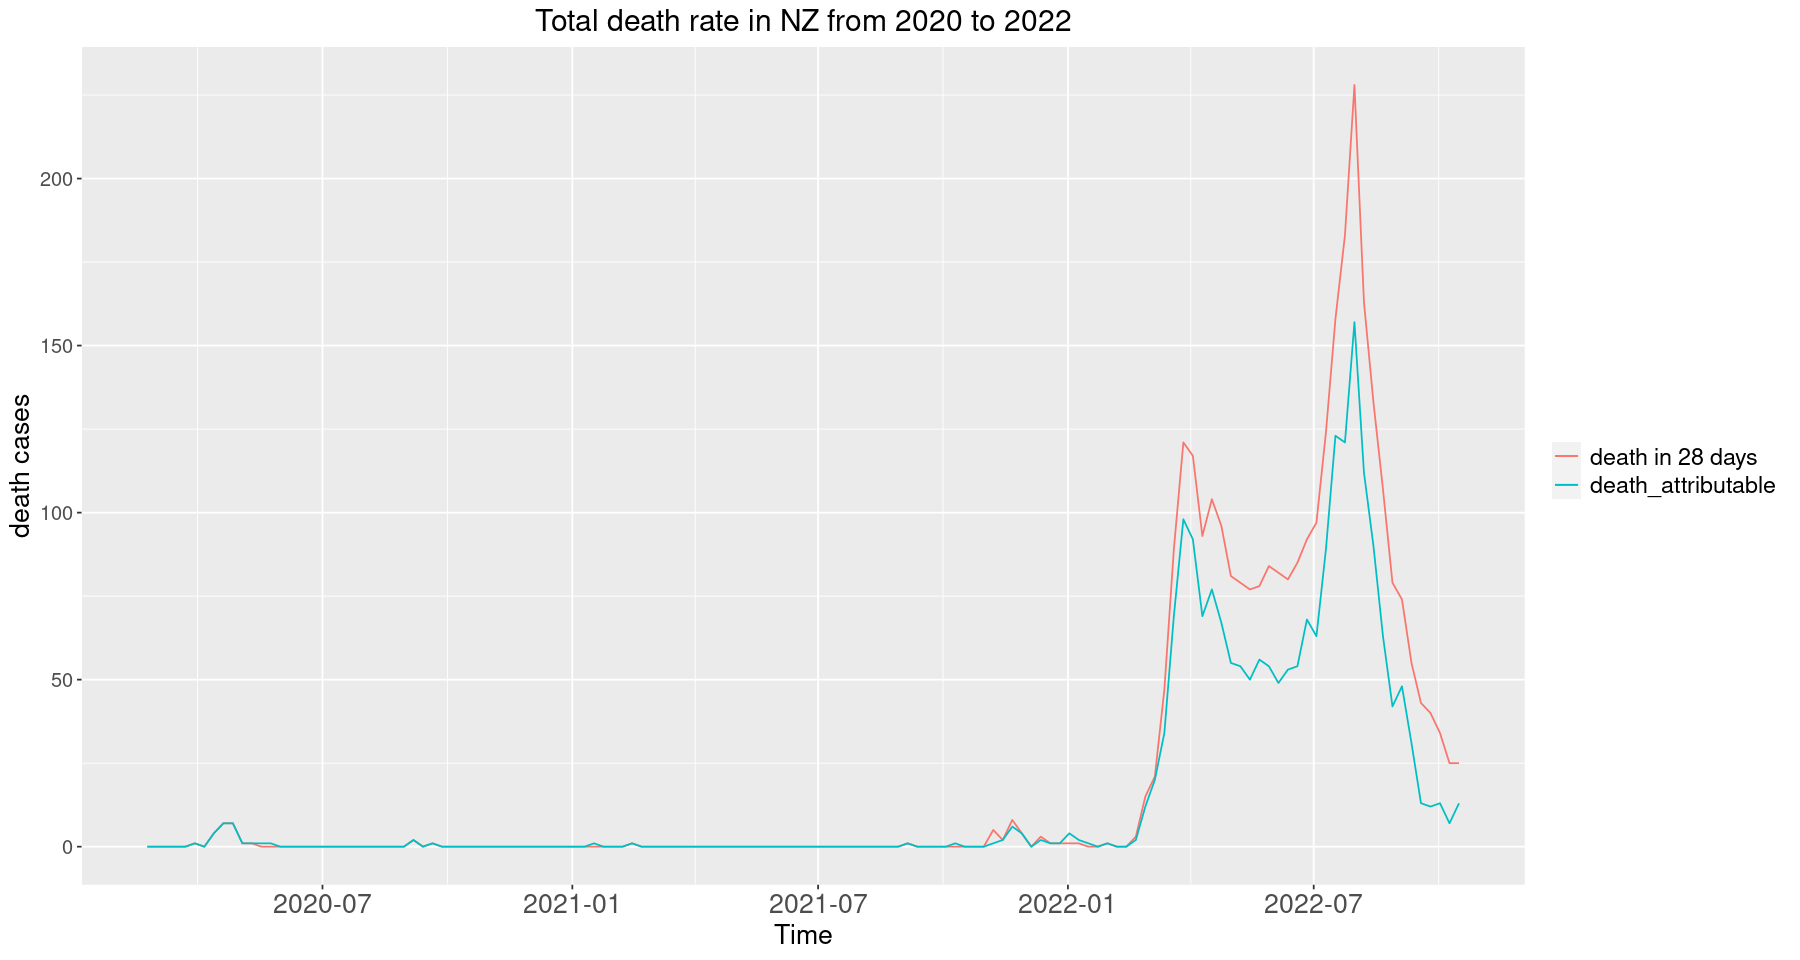

In [191]:
# now make a graph of death rate from 2020 to 2022
death_data_graph <- death_data %>%
        ggplot(aes(x=weekly_date)) + 
        ggtitle('Total death rate in NZ from 2020 to 2022') + 
        geom_line(aes(y=death_in_28_days, color="death in 28 days"),position = position_dodge(0.2)) +
        # geom_point(aes(y=death_in_28_days),position = position_dodge(0.2), size=2) +
        geom_line(aes(y=death_attributable, color="death_attributable"),position = position_dodge(0.2)) +
        # geom_point(aes(y=death_attributable),position = position_dodge(0.2), size=2) +
        # geom_text(aes(y=death_in_28_days, label= death_in_28_days), position=position_dodge(width=0.9), vjust=-0.75) +
        # geom_text(aes(y=death_attributable, label= death_attributable), position=position_dodge(width=0.9), vjust=-0.75) +
        theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=16), 
              axis.text.x = element_text(size=16),
              axis.text.y = element_text(size=12),
              legend.title=element_blank(),
              legend.position = "right", 
              legend.text = element_text(size=14)) + 
        xlab("Time") + ylab("death cases")
death_data_graph

> 5. like what we did with death cases, now add vaccine uptake cases into it

In [192]:
vac_tes_death_table <- merge(vac_tes_table, death_data, by="weekly_date")

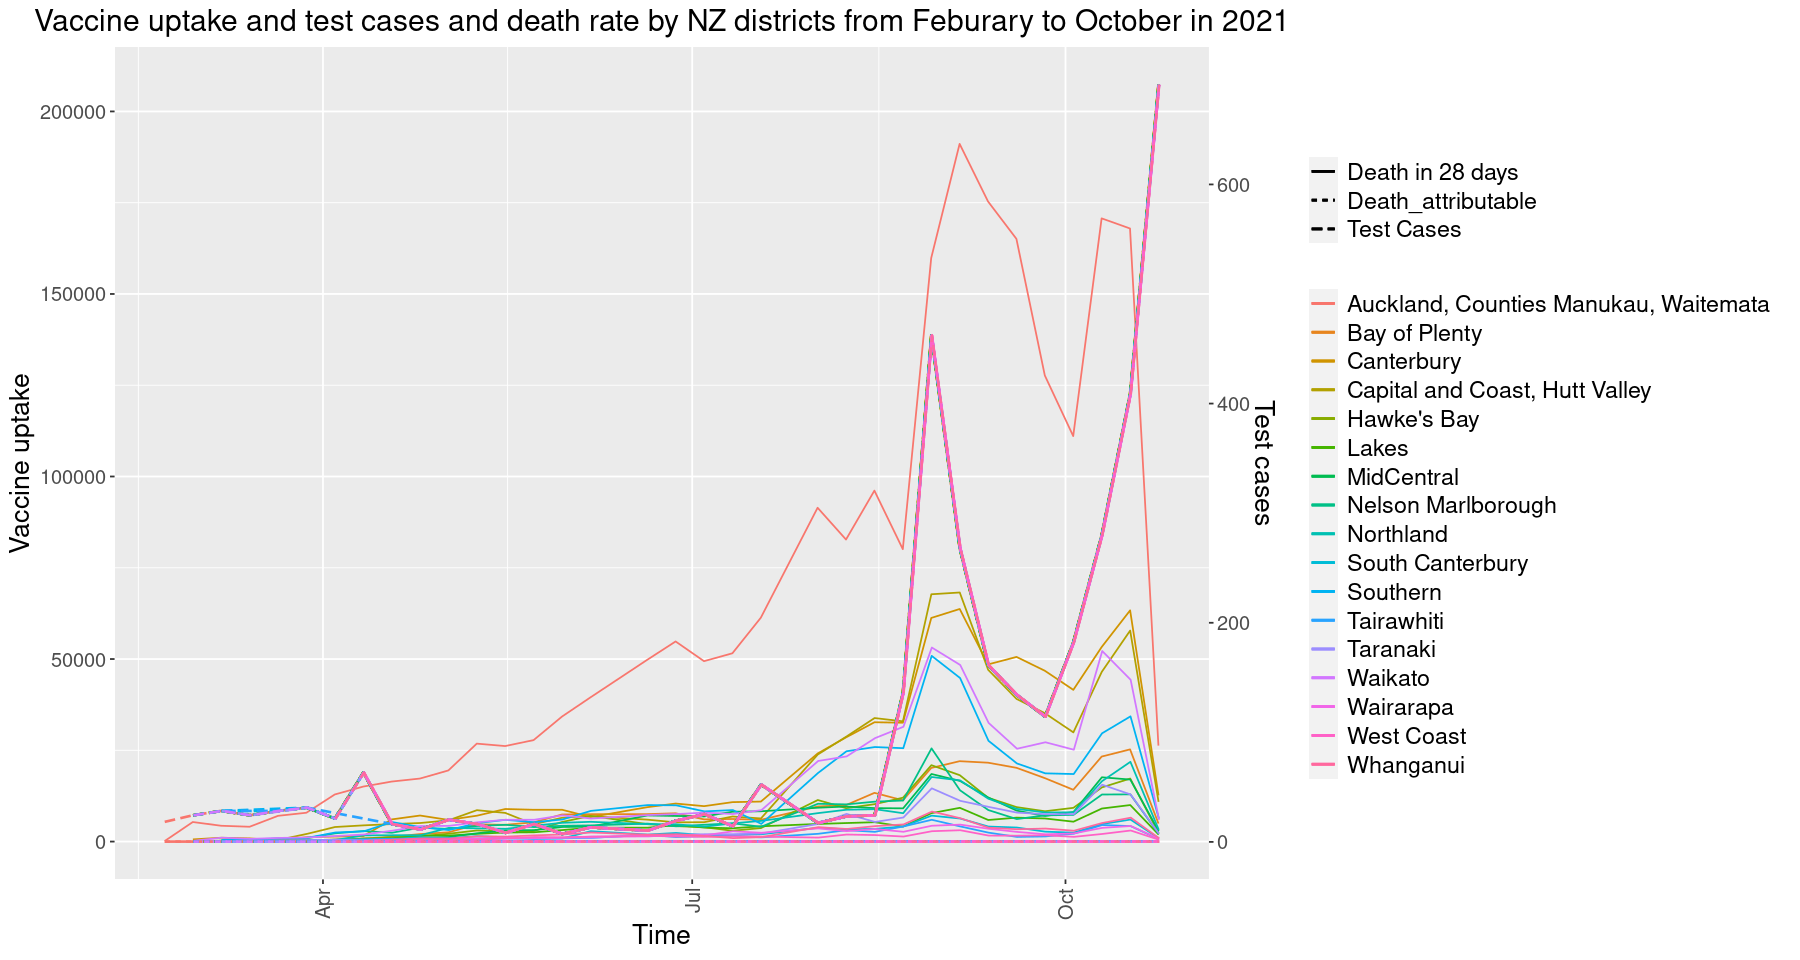

In [193]:
# the final graph to cover everything
vac_tes_death_table_graph <- vac_tes_death_table %>% 
        # filter(all_districts == "Auckland, Counties Manukau, Waitemata") %>%
        ggplot(aes(x=weekly_date, color=all_districts, group=all_districts)) + 
        ggtitle('Vaccine uptake and test cases and death rate by NZ districts from Feburary to October in 2021') + 
        geom_line(aes(y=total_uptake_number, color=all_districts), position = position_dodge(0.2)) +
        # geom_point(aes(y=total_uptake_number), position = position_dodge(0.2), size=2) +
        geom_line(aes(y=weekly_total_cases*300, linetype ='Test Cases'), position = position_dodge(0.2), size = 0.75) +
        # geom_point(aes(y=WeeklyCases), position = position_dodge(0.2), size=2) +
        geom_line(aes(y=death_in_28_days, linetype ='Death in 28 days'), position = position_dodge(0.2), size = 0.75) +
        geom_line(aes(y=death_attributable, linetype ='Death_attributable'), position = position_dodge(0.2), size = 0.75) +
        # geom_text(aes(label=total_uptake_number), position=position_dodge(width=0.9), vjust=-0.75) +
        theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=16), 
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size=12),
              axis.text.y = element_text(size=12),
              legend.title=element_blank(),
              legend.position = "right", 
              legend.text = element_text(size=14)) +
            scale_y_continuous(
                name = "Vaccine uptake",
                sec.axis = sec_axis(~./300, name="Test cases")) + 
        # scale_linetype_manual(name = "Data types", values = c("Death in 28 days" = "darkblue", "Death_attributable" = "red", "Test cases" = "purple")) + 
        xlab("Time")
        
vac_tes_death_table_graph

#### Create the vaccine rate by districts

> 1. We need to change the district name according to nz shapefile to merge them together

In [194]:
# clean the data to match the name of districts
vac_location_table <- vac_tes_death_table %>% 
        group_by(all_districts) %>% 
        summarise(total_uptake_number = sum(total_uptake_number)) %>%
        filter(!row_number() %in% c(1, 4, 5, 7, 8, 10, 11))
        
sep <- data.frame(all_districts=c("Auckland", "Counties Manukau", "Waitemata", "Wellington", "Hutt Valley", "Nelson", "Marlborough", "Manawatu-Wanganui", "Hawke\'s Bay", "Southland", "Otago"),
                   total_uptake_number=c(761762, 761762, 761762, 316420, 316420, 106650, 106650, 215276, 213648, 457785, 78654))
vac_location_table %<>% rbind(sep)

> 2. now add vaccine rate column into nz map shapefile 

In [195]:
# clean up the vaccine table to get real vaccine rate by percentage
vac_rate_table <- vac_location_table %>% 
  filter(all_districts %in% nz_map$NAME_1) %>%
  group_by(all_districts) %>%
  summarise(vaccine_rate = total_uptake_number/sum(vac_location_table$total_uptake_number))

nz_map$vaccine_rate <- vac_rate_table$vaccine_rate[match(nz_map$NAME_1, vac_rate_table$all_districts)]

> 3. The last but not the least, create the plot of vaccine rate by district in 2021

Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”
Warning message:
“position_dodge requires non-overlapping x intervals”


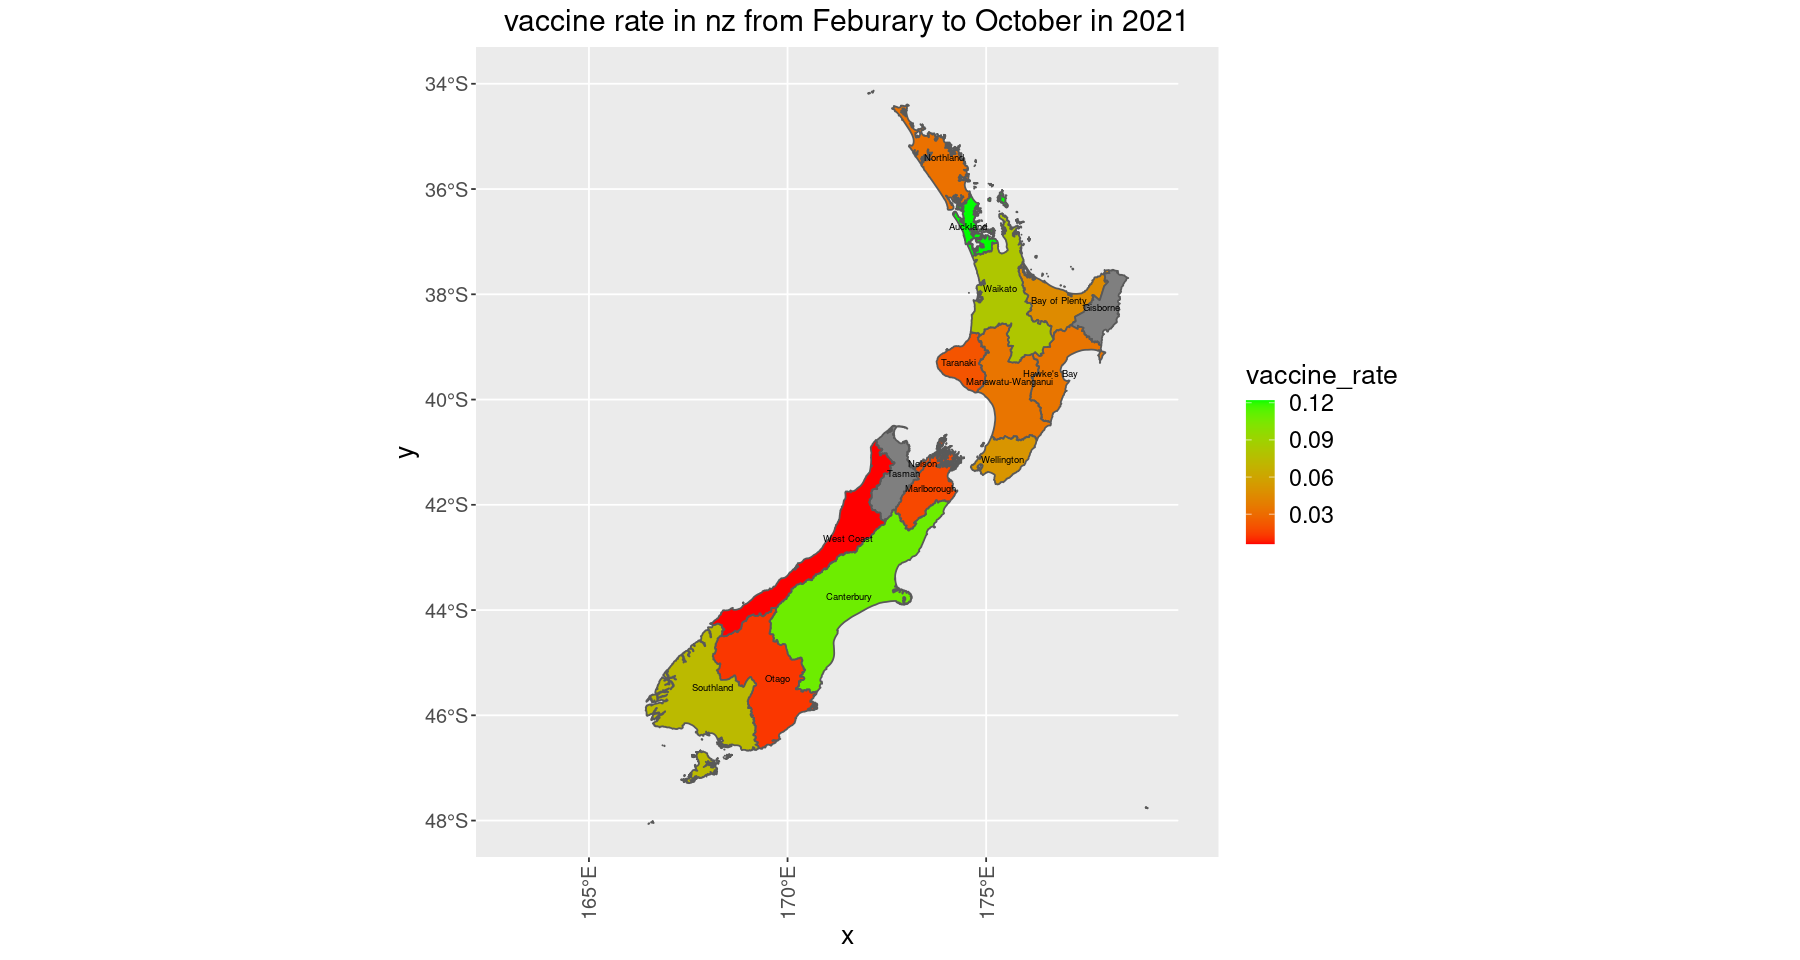

In [196]:
# draw the vaccine map by districts
vac_rate_map <- ggplot(nz_map) + 
    geom_sf(aes(fill = vaccine_rate)) +
    ggtitle("vaccine rate in nz from Feburary to October in 2021") +
    coord_sf(xlim = c(163,180),
            ylim = c(-48,-34)) +
    geom_sf_text(aes(label = NAME_1), position=position_dodge(1.7), size=2) +
    theme(plot.title = element_text(hjust = 0.5, size=18), 
              axis.title=element_text(size=16), 
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size=12),
              axis.text.y = element_text(size=12),
              legend.title = element_text(size=16),
              legend.position = "right", 
              legend.text = element_text(size=14)) +
    scale_fill_gradient(low = "red", high = "green")

vac_rate_map